# Final Bootcamp Project | Predicting Coffee Prices

Table of Contents:

1. [Introduction](#intro)
2. [Import Libraries](#importlib)
3. [Get data](#getdata)
    1. [What could influence the price of coffee](#influence)
    2. Target Value: Daily Coffee Price
    3. Supply: Geopolitics
    4. Supply: Transportation
    5. Supply: Influence on production (Weather)
    6. Supply: Production Volumes
    7. Demand: Import Volumes
    8. Demand: Re-Export Volumes
    9. Demand: Inflation OECD
    10. Demand: Unemployment Rate
    11. Demand: Currency Exchange Rate EUR€-US$
    12. Demand: Growth Emerging Coffee Market
    13. Combining Data to obtain Dataset
4. [Cleaning/Wrangling/EDA](#cleaning)

5. [Modeling](#modeling)
    1. [X/y-Split](#pXy)
    2. Selecting Best Features with KBest Algorithm
    3. Correlation
    4. [Train/Test split](#pTT)
    5. [transformations on numericals](#pNum)
    6. [combine train and test-data](#pCombineTrain)
    7. Modeling: Choose the best Model
    8. Hyperparameter Search: Grid Search
    9. Apply Model on full dataset.
9. [Reporting](#reporting)

<a id='intro'></a>
## 1. Introduction

<a id='importlib'></a>
## 2. Import Libraries

In [1]:
import pandas as pd
import numpy as np

import warnings
warnings.filterwarnings('ignore')

# for target
#pip install yfinance
#pip install yfinance --upgrade --no-cache-dir 
import yfinance as yf

#for plots
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

#train-test-split
from sklearn.model_selection import train_test_split

#scaling numerical variables
from sklearn.preprocessing import MinMaxScaler
# from sklearn.preprocessing import StandardScaler

# #categorical variables
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.preprocessing import LabelEncoder
# from sklearn.preprocessing import OrdinalEncoder

#for regression
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score

#for KBest Feature Selection
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

#for Hypertuning
from sklearn.model_selection import GridSearchCV

#for stats
import scipy.stats as stats

#for time/dates
import time
from datetime import date
from datetime import datetime

# #for clustering
# from sklearn import cluster, datasets
# from sklearn.cluster import KMeans
# import pickle
# from sklearn.metrics import silhouette_score

# for API
import json
import requests

# respectful nap
from random import randint
from time import sleep

<a id='getdata'></a>
## 3. Get Data

<a id='influence'></a>
### What could influence the Price of Coffee?

1. Supply:
    1. Geopolitics:
        1. Political Stability
        2. Currency Exchange Rate  

    2. Production
        1. Climate (Weather Data 5 biggest producer countries): The top five coffee-producing countries account for about two-thirds of global production, and the two largest producers – Brazil and Vietnam – often account for about half of annual production.
            1. Brazil
            2. Vietnam
            3. Colombia
            4. Indonesia
            5. Ethiopia 


        2. Production Volume
        3. Inventory Volume  

    4. Transportation
        1. Oil Prices  

2. Demand:
    1. Income / Economic Situation of importing countries 
        1. Inflation (OECD)
        2. Unemployment Rate (Europe 19 countries)
        3. Economig Growth in Emerging Markets for Coffee (GDP China)

### Get Data - Target Value: Daily Coffee Price

- Source: https://finance.yahoo.com/quote/KC%3DF?p=KC%3DF 
- Data Type: yahoofinance python library 
- Range 03.01.2000 - present (26.01.2023)  
Data prior on a daily basis is not available for free neither on finance yahoo nor on the ico website (https://www.ico.org/new_historical.asp).

- Data Precision: daily (when markets are open)
- Data Information: Prices are in [US cents/lb] and the volume in [lb]

In [2]:
yahoo_import_coffee = yf.download('KC=F', start="2000-01-04", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [3]:
data_coffee_price = yahoo_import_coffee
display(data_coffee_price.shape)
data_coffee_price.head()

(5763, 6)

Open        High         Low       Close  \
Date                                                                    
2000-01-04 00:00:00-05:00  116.50  120.500000  115.750000  116.250000   
2000-01-05 00:00:00-05:00  115.00  121.000000  115.000000  118.599998   
2000-01-06 00:00:00-05:00  119.00  121.400002  116.500000  116.849998   
2000-01-07 00:00:00-05:00  117.75  117.750000  113.800003  114.150002   
2000-01-10 00:00:00-05:00  126.00  126.000000  116.699997  117.550003   

                            Adj Close  Volume  
Date                                           
2000-01-04 00:00:00-05:00  116.250000    5492  
2000-01-05 00:00:00-05:00  118.599998    6165  
2000-01-06 00:00:00-05:00  116.849998    5094  
2000-01-07 00:00:00-05:00  114.150002    6855  
2000-01-10 00:00:00-05:00  117.550003    7499

In [4]:
# Function to clean yahoo-datasets:

def clean_yahoo(df):
    df = df.pivot_table(index= ['Date']).reset_index()
    # daily average
    df['daily_average'] = (df['Open'] +  df['Close'])*0.5
    # dropping useless columns:
    df = df.drop(columns= ['Adj Close', 'Close', 'High', 'Low', 'Open'], axis=1)
    # standardize header names
    df.columns = [e.lower().replace(' ', '_') for e in df.columns]
    # clean date
    df.date = df.date.astype(str).str.split(" ").str[0].astype('datetime64')
    df.date = pd.to_datetime(df.date, format='%Y-%M-%d')
    return df


In [5]:
data_coffee_price = clean_yahoo(data_coffee_price)
data_coffee_price.head()

date  volume  daily_average
0 2000-01-04    5492     116.375000
1 2000-01-05    6165     116.799999
2 2000-01-06    5094     117.924999
3 2000-01-07    6855     115.950001
4 2000-01-10    7499     121.775002

In [6]:
#rename column names for merging later.
data_coffee_price=data_coffee_price.rename(columns={'volume':'volume_coffee_traded',
                            'daily_average':'daily_average_coffee_price',
                            })

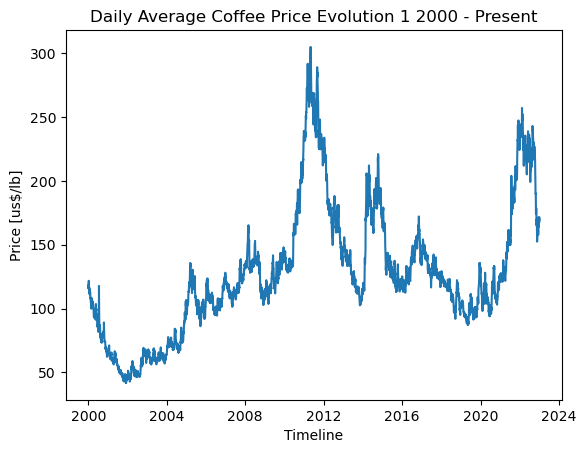

In [7]:
plt.plot(data_coffee_price.date,data_coffee_price.daily_average_coffee_price)
plt.xlabel('Timeline')
plt.ylabel('Price [us$/lb]')
plt.title('Daily Average Coffee Price Evolution 1 2000 - Present')
plt.show()

### Get Data - Supply: Geopolitics (Liberal Democracy Scores)

- Source: https://ourworldindata.org/grapher/liberal-democracy-row
- Data Type: .csv - file
- Range: 2000 - 2021
- Data precision: yearly
- Data Information: Rate [0-1]

In [8]:
data_liberal_democracy = pd.read_csv('./Collected_Datasets/liberal-democracy.csv')

In [9]:
display(data_liberal_democracy.shape)
data_liberal_democracy.head()

(30858, 6)

Entity Code  Year  libdem_vdem_owid  libdem_vdem_low_owid  \
0  Afghanistan  AFG  1789             0.035                 0.017   
1  Afghanistan  AFG  1790             0.035                 0.017   
2  Afghanistan  AFG  1791             0.035                 0.017   
3  Afghanistan  AFG  1792             0.035                 0.017   
4  Afghanistan  AFG  1793             0.035                 0.017   

   libdem_vdem_high_owid  
0                  0.046  
1                  0.046  
2                  0.046  
3                  0.046  
4                  0.046

In [10]:
data_liberal_democracy.Entity.unique()

array(['Afghanistan', 'Africa', 'Albania', 'Algeria', 'Angola',
       'Argentina', 'Armenia', 'Asia', 'Australia', 'Austria',
       'Azerbaijan', 'Baden', 'Bahrain', 'Bangladesh', 'Barbados',
       'Bavaria', 'Belarus', 'Belgium', 'Benin', 'Bhutan', 'Bolivia',
       'Bosnia and Herzegovina', 'Botswana', 'Brazil', 'Brunswick',
       'Bulgaria', 'Burkina Faso', 'Burundi', 'Cambodia', 'Cameroon',
       'Canada', 'Cape Verde', 'Central African Republic', 'Chad',
       'Chile', 'China', 'Colombia', 'Comoros', 'Congo', 'Costa Rica',
       "Cote d'Ivoire", 'Croatia', 'Cuba', 'Cyprus', 'Czechia',
       'Democratic Republic of Congo', 'Denmark', 'Djibouti',
       'Dominican Republic', 'East Germany', 'Ecuador', 'Egypt',
       'El Salvador', 'Equatorial Guinea', 'Eritrea', 'Estonia',
       'Eswatini', 'Ethiopia', 'Europe', 'Fiji', 'Finland', 'France',
       'Gabon', 'Gambia', 'Georgia', 'Germany', 'Ghana', 'Greece',
       'Guatemala', 'Guinea', 'Guinea-Bissau', 'Guyana', 'Haiti',
 

In [11]:
# years we are interested in
year = list(range(2000,2023,1))
# countries we are interested in
countries = ['Brazil', 'Colombia', 'Indonesia','Ethiopia','Vietnam']

In [12]:
data_liberal_democracy_top_five = (data_liberal_democracy[(data_liberal_democracy['Entity'].isin(countries)) & (data_liberal_democracy['Year'].isin(year))]).reset_index(drop=True)

In [13]:
data_liberal_democracy_top_five.head()

Entity Code  Year  libdem_vdem_owid  libdem_vdem_low_owid  \
0  Brazil  BRA  2000             0.740                 0.694   
1  Brazil  BRA  2001             0.740                 0.694   
2  Brazil  BRA  2002             0.744                 0.695   
3  Brazil  BRA  2003             0.746                 0.700   
4  Brazil  BRA  2004             0.746                 0.700   

   libdem_vdem_high_owid  
0                  0.800  
1                  0.800  
2                  0.798  
3                  0.803  
4                  0.803

In [14]:
data_liberal_democracy_top_five = data_liberal_democracy_top_five[['Entity','Year', 'libdem_vdem_owid']]

In [15]:
data_liberal_democracy_top_five = data_liberal_democracy_top_five.pivot(index=['Year'],columns='Entity', values='libdem_vdem_owid').reset_index()
data_liberal_democracy_top_five.head()

Entity  Year  Brazil  Colombia  Ethiopia  Indonesia  Vietnam
0       2000   0.740     0.430     0.115      0.518    0.099
1       2001   0.740     0.426     0.115      0.518    0.099
2       2002   0.744     0.424     0.115      0.521    0.099
3       2003   0.746     0.429     0.114      0.530    0.099
4       2004   0.746     0.430     0.114      0.542    0.099

In [16]:
#rename column names for merging later.
# standardize header names
data_liberal_democracy_top_five.columns = [e.lower().replace(' ', '_') for e in data_liberal_democracy_top_five.columns]
data_liberal_democracy_top_five=data_liberal_democracy_top_five.add_suffix('_lib_dem')
data_liberal_democracy_top_five=data_liberal_democracy_top_five.rename(columns={'year_lib_dem':'date'})

In [17]:
data_liberal_democracy_top_five.head()

date  brazil_lib_dem  colombia_lib_dem  ethiopia_lib_dem  \
0  2000           0.740             0.430             0.115   
1  2001           0.740             0.426             0.115   
2  2002           0.744             0.424             0.115   
3  2003           0.746             0.429             0.114   
4  2004           0.746             0.430             0.114   

   indonesia_lib_dem  vietnam_lib_dem  
0              0.518            0.099  
1              0.518            0.099  
2              0.521            0.099  
3              0.530            0.099  
4              0.542            0.099

In [18]:
data_liberal_democracy_top_five.date = pd.to_datetime(data_liberal_democracy_top_five.date, format='%Y')
data_liberal_democracy_top_five.tail()

date  brazil_lib_dem  colombia_lib_dem  ethiopia_lib_dem  \
17 2017-01-01           0.639             0.539             0.104   
18 2018-01-01           0.617             0.536             0.145   
19 2019-01-01           0.512             0.510             0.175   
20 2020-01-01           0.508             0.484             0.161   
21 2021-01-01           0.512             0.471             0.151   

    indonesia_lib_dem  vietnam_lib_dem  
17              0.492            0.143  
18              0.465            0.136  
19              0.476            0.126  
20              0.446            0.112  
21              0.428            0.126

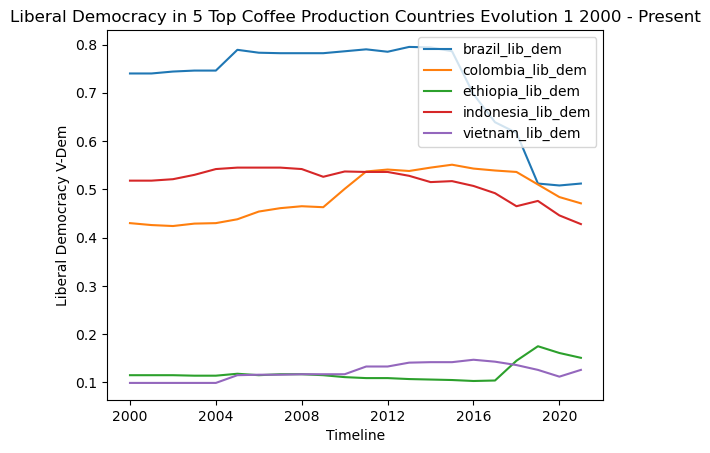

In [19]:
for column in data_liberal_democracy_top_five.columns[1:]:
    plt.plot(data_liberal_democracy_top_five['date'],data_liberal_democracy_top_five[column],label=column)
plt.xlabel('Timeline')
plt.ylabel('Liberal Democracy V-Dem')
plt.title('Liberal Democracy in 5 Top Coffee Production Countries Evolution 1 2000 - Present')
plt.legend()
plt.show()

In [20]:
def upsample(df,lastdate_to_replace, lastdate_value):
    #We duplicate the last row and replace it with 2020-01-01, in order to get the days of the whole year 2019. After we are going to drop it again.
    new_df = pd.DataFrame(df[-1:].values, columns=df.columns)
    new_df['date'] = new_df['date'].replace([lastdate_to_replace], lastdate_value)
    df = df.append(new_df).reset_index(drop=True)
    #set date as index
    df = df.set_index('date')
    #resample
    df = df.resample('d').ffill().reset_index()
    #drop the last row, since it was copied, to make the resampling bigger.
    df = df[df['date']!=lastdate_value]
    return df


In [21]:
data_liberal_democracy_top_five_daily = upsample(data_liberal_democracy_top_five,'2021-01-01','2022-01-01')
data_liberal_democracy_top_five_daily.head()

date brazil_lib_dem colombia_lib_dem ethiopia_lib_dem  \
0 2000-01-01           0.74             0.43            0.115   
1 2000-01-02           0.74             0.43            0.115   
2 2000-01-03           0.74             0.43            0.115   
3 2000-01-04           0.74             0.43            0.115   
4 2000-01-05           0.74             0.43            0.115   

  indonesia_lib_dem vietnam_lib_dem  
0             0.518           0.099  
1             0.518           0.099  
2             0.518           0.099  
3             0.518           0.099  
4             0.518           0.099

### Get Data - Supply: Transportation: Crude Oil

- Source: https://de.finance.yahoo.com/quote/CL=F?p=CL=F&.tsrc=fin-srch
- Data Type: yahoofinance python library
- Range: 03.01.2000 - present (26.01.2023) 
- Data precision: daily (when markets are open)
- Data Information: Prices are in [US cents/barrel] and the volume in [lb]

In [22]:
yahoo_import_oil = yf.download('CL=F', start="2000-01-04", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [23]:
data_oil_price = yahoo_import_oil
display(data_oil_price.shape)
data_oil_price.head(5)

(5615, 6)

Open       High        Low      Close  \
Date                                                                    
2000-08-23 00:00:00-04:00  31.950001  32.799999  31.950001  32.049999   
2000-08-24 00:00:00-04:00  31.900000  32.240002  31.400000  31.629999   
2000-08-25 00:00:00-04:00  31.700001  32.099998  31.320000  32.049999   
2000-08-28 00:00:00-04:00  32.040001  32.919998  31.860001  32.869999   
2000-08-29 00:00:00-04:00  32.820000  33.029999  32.560001  32.720001   

                           Adj Close  Volume  
Date                                          
2000-08-23 00:00:00-04:00  32.049999   79385  
2000-08-24 00:00:00-04:00  31.629999   72978  
2000-08-25 00:00:00-04:00  32.049999   44601  
2000-08-28 00:00:00-04:00  32.869999   46770  
2000-08-29 00:00:00-04:00  32.720001   49131

In [24]:
data_oil_price = clean_yahoo(data_oil_price)
data_oil_price.head()

date  volume  daily_average
0 2000-08-23   79385      32.000000
1 2000-08-24   72978      31.764999
2 2000-08-25   44601      31.875000
3 2000-08-28   46770      32.455000
4 2000-08-29   49131      32.770000

In [25]:
#keep only date and daily_average and rename column names for merging later.
data_oil_price = data_oil_price[['date','daily_average']]
data_oil_price=data_oil_price.rename(columns={'daily_average':'daily_average_oil_price'})

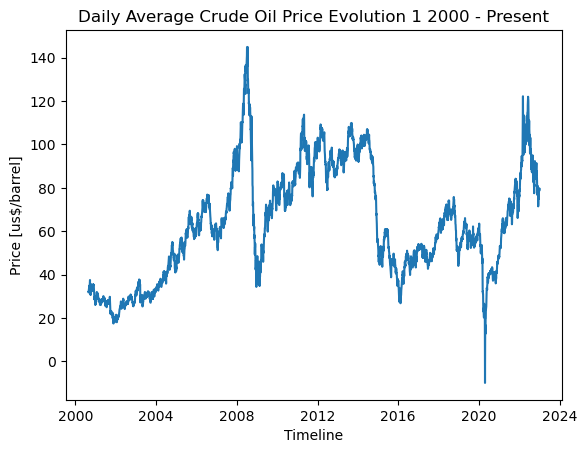

In [26]:
plt.plot(data_oil_price.date,data_oil_price.daily_average_oil_price)
plt.xlabel('Timeline')
plt.ylabel('Price [us$/barrel]')
plt.title('Daily Average Crude Oil Price Evolution 1 2000 - Present')
plt.show()

### Get Data - Supply: Influence on production: Weather

- Source: https://power.larc.nasa.gov/data-access-viewer/
- Data Type: API
- Range: 03.01.2000 - 31.12.2022 
- Data precision: daily
- Data Information:
    - Chosen Parameters:
        - FROST_DAYS = A frost day occurs when the 2m temperature cools to the dew point temperature and both are less than 0 C or 32 F.  
        - PRECTOTCORR = The bias corrected average of total precipitation at the surface of the earth in water mass (includes water content in snow).  
    - Chosen Locations:
        - Locations:
            - Brazil (minas gerais, alta mogiana, rondonia)
            - Colombia (bella vista, highlands)
            - Ethiopia (kuri mountain, shilcho)
            - Vietnam

In [27]:
locations = [
    ['brazil_minas_gerais', '-20.99381692482433','-45.58331824167786'],
    ['brazil_alta_mogiana', '-20.25146199857644', '-47.60632683831677'],
    ['brazil_rondonia', '-9.340339865405975', '-63.8862970848236'],
    ['colombia_bella_vista', '4.439678121124939', '-75.81569291434761'],
    ['colombia_highlands', '5.674896883020882', '-73.4710397381943'],
    ['ethiopia_kuri_mountain', '8.993191517998033', '34.601556339696764'],
    ['ethiopia_shilcho_coop', '6.489290766609294', '38.38969597625702'],
    ['vietnam', '12.766856113119104', '108.00508881051391']
]

In [28]:
locations[0][0]

'brazil_minas_gerais'

In [29]:
locations_df = pd.DataFrame(locations, columns = ['location', 'latitude','longitude'])
locations_df

location            latitude           longitude
0     brazil_minas_gerais  -20.99381692482433  -45.58331824167786
1     brazil_alta_mogiana  -20.25146199857644  -47.60632683831677
2         brazil_rondonia  -9.340339865405975   -63.8862970848236
3    colombia_bella_vista   4.439678121124939  -75.81569291434761
4      colombia_highlands   5.674896883020882   -73.4710397381943
5  ethiopia_kuri_mountain   8.993191517998033  34.601556339696764
6   ethiopia_shilcho_coop   6.489290766609294   38.38969597625702
7                 vietnam  12.766856113119104  108.00508881051391

In [30]:
#save for visualization purpose:
locations_df.to_csv('locations_df.csv', index=False)

In [31]:
nested_locations = []
for loc in range(len(locations)):
    nested_locations.append(locations[loc][0])
nested_locations

['brazil_minas_gerais',
 'brazil_alta_mogiana',
 'brazil_rondonia',
 'colombia_bella_vista',
 'colombia_highlands',
 'ethiopia_kuri_mountain',
 'ethiopia_shilcho_coop',
 'vietnam']

In [32]:
# we can only access the API for a period of max. 366 days.
start = (np.arange(20010101, 20230101,10000)).tolist()
start = [str(x) for x in start]
start.insert(0, "20000104")
display(len(start))
start

23

['20000104',
 '20010101',
 '20020101',
 '20030101',
 '20040101',
 '20050101',
 '20060101',
 '20070101',
 '20080101',
 '20090101',
 '20100101',
 '20110101',
 '20120101',
 '20130101',
 '20140101',
 '20150101',
 '20160101',
 '20170101',
 '20180101',
 '20190101',
 '20200101',
 '20210101',
 '20220101']

In [33]:
end = (np.arange(20001231, 20231231,10000)).tolist()
end = [str(x) for x in end]
display(len(end))
end

23

['20001231',
 '20011231',
 '20021231',
 '20031231',
 '20041231',
 '20051231',
 '20061231',
 '20071231',
 '20081231',
 '20091231',
 '20101231',
 '20111231',
 '20121231',
 '20131231',
 '20141231',
 '20151231',
 '20161231',
 '20171231',
 '20181231',
 '20191231',
 '20201231',
 '20211231',
 '20221231']

In [34]:
parameters = ['FROST_DAYS' , 'PRECTOTCORR']
parameter_API = (','.join(parameters))

In [35]:
# get for every location (8), for every year (2000-2022) the frost_days
# this will be stored in dictionary: location with 1st key being the location and 2nd key being the year, the value being the JSON-Result from the API.
results = []
results_API_location = {}
for l in range(len(locations)):     #for every location
    for st, e in zip(start, end):   #for every year
        # print(st,e)
        URL = "https://power.larc.nasa.gov/api/temporal/daily/point?start="+st+"&end="+e+"&latitude="+locations[l][1]+"&longitude="+locations[l][2]+"&community=ag&parameters="+parameter_API+"&format=json&header=true&time-standard=lst"
        
        PowerNASA = requests.get(URL)
        results.append(PowerNASA.json())
    results_API_location[locations[l][0]] = results
    results = []
    sleep((randint(1,3000)/1000))# a respectful nap

In [36]:
results_API_location['brazil_minas_gerais'][0]['properties']['parameter']['FROST_DAYS']
results_API_location['brazil_minas_gerais'][0]['properties']['parameter']['PRECTOTCORR']

{'20000104': 34.03,
 '20000105': 7.35,
 '20000106': 10.98,
 '20000107': 1.6,
 '20000108': 1.06,
 '20000109': 0.01,
 '20000110': 0.05,
 '20000111': 0.71,
 '20000112': 0.84,
 '20000113': 0.23,
 '20000114': 1.49,
 '20000115': 1.38,
 '20000116': 10.17,
 '20000117': 12.79,
 '20000118': 2.29,
 '20000119': 9.21,
 '20000120': 5.42,
 '20000121': 0.76,
 '20000122': 0.59,
 '20000123': 2.89,
 '20000124': 20.44,
 '20000125': 7.02,
 '20000126': 22.91,
 '20000127': 30.34,
 '20000128': 8.87,
 '20000129': 4.29,
 '20000130': 14.74,
 '20000131': 17.54,
 '20000201': 16.36,
 '20000202': 5.13,
 '20000203': 1.09,
 '20000204': 2.91,
 '20000205': 7.64,
 '20000206': 15.34,
 '20000207': 22.53,
 '20000208': 32.62,
 '20000209': 10.63,
 '20000210': 13.07,
 '20000211': 11.83,
 '20000212': 7.85,
 '20000213': 1.25,
 '20000214': 1.11,
 '20000215': 0.22,
 '20000216': 4.74,
 '20000217': 19.68,
 '20000218': 5.56,
 '20000219': 0.31,
 '20000220': 0.02,
 '20000221': 0.22,
 '20000222': 0.04,
 '20000223': 0.21,
 '20000224': 5.

In [37]:
len(results_API_location['brazil_minas_gerais'])

23

In [38]:
# unpack the json information:
# this will be stored in a dictionary: res_year_par_loc

res = []                    # results for each parameter for each year stored in a list 1st key: date, 2nd level: values
res_year = {}               # results for each parameter stored in a dict with 1st key: parameter, 2nd key: date, 3rd level: values
res_year_par = {}           # all parameters are stored in a dictionary with 1st key: parameter, 2nd key: year, 3rd key: date, 4th level: values
res_year_par_loc = {}       # all locations & their parameters are stored in a dictionary with 1st key: location, 2nd key: parameter, 3rd key: year, 4th key: date, 5th level: values

for loc in nested_locations:                                # for every location (8)
    for p in parameters:                                    # for every parameter (2)
        for r in range(len(results_API_location[loc])):     # for every year (23)
            res.append(results_API_location[loc][r]['properties']['parameter'][p])
            
        res_year_par[p] = res 
        res = []

    res_year_par_loc[loc] = res_year_par
    res_year_par = {}

In [39]:
print(len(res_year_par_loc), type(res_year_par_loc))                                                                                        # Should be the number of locations  - here 8
print(len(res_year_par_loc['brazil_minas_gerais']), type(res_year_par_loc['brazil_minas_gerais']))                                          # Should be the number of parameters selected - here 2 ['FROST_DAYS'][0])
print(len(res_year_par_loc['brazil_minas_gerais']['FROST_DAYS']),type(res_year_par_loc['brazil_minas_gerais']['FROST_DAYS']))               # Should be the number of years - 23
print(len(res_year_par_loc['brazil_minas_gerais']['FROST_DAYS'][0]),type(res_year_par_loc['brazil_minas_gerais']['FROST_DAYS'][0]))         # Should be the number of days in a year - 365/366

8 <class 'dict'>
2 <class 'dict'>
23 <class 'list'>
363 <class 'dict'>


In [40]:
for loc in nested_locations:
    for p in parameters:
        res_year_par_loc[loc][p] = dict((key,d[key]) for d in res_year_par_loc[loc][p] for key in d)

In [41]:
print(len(res_year_par_loc), type(res_year_par_loc))                                                                                        # Should be the number of locations  - here 8
print(len(res_year_par_loc['brazil_minas_gerais']), type(res_year_par_loc['brazil_minas_gerais']))                                          # Should be the number of parameters selected - here 2 ['FROST_DAYS'][0])
print(len(res_year_par_loc['brazil_minas_gerais']['FROST_DAYS']),type(res_year_par_loc['brazil_minas_gerais']['FROST_DAYS']))               # Should be the total number of days - 8427

8 <class 'dict'>
2 <class 'dict'>
8398 <class 'dict'>


In [42]:
#Put all the information into a dataframe
weather_data = pd.DataFrame()
for column in nested_locations:  
    flattened = pd.DataFrame(dict(res_year_par_loc[column]))
    flattened.columns = [column + '_' + str(colname) for colname in flattened.columns]
    weather_data = pd.concat([weather_data, flattened], axis=1)


In [43]:
weather_data= weather_data.reset_index()
weather_data.rename(columns = {'index': 'date'}, inplace=True)
weather_data.date = pd.to_datetime(weather_data.date, format='%Y%m%d')
weather_data

date  brazil_minas_gerais_FROST_DAYS  \
0    2000-01-04                             0.0   
1    2000-01-05                             0.0   
2    2000-01-06                             0.0   
3    2000-01-07                             0.0   
4    2000-01-08                             0.0   
...         ...                             ...   
8393 2022-12-27                             0.0   
8394 2022-12-28                             0.0   
8395 2022-12-29                             0.0   
8396 2022-12-30                             0.0   
8397 2022-12-31                             0.0   

      brazil_minas_gerais_PRECTOTCORR  brazil_alta_mogiana_FROST_DAYS  \
0                               34.03                             0.0   
1                                7.35                             0.0   
2                               10.98                             0.0   
3                                1.60                             0.0   
4                                1.06                             0.0   
...                               ...                             ...   
8393                             0.92                             0.0   
8394                             7.18                             0.0   
8395                             4.95                             0.0   
8396                             6.50                             0.0   
8397                             5.62                             0.0   

      brazil_alta_mogiana_PRECTOTCORR  brazil_rondonia_FROST_DAYS  \
0                               38.22                         0.0   
1                               10.19                         0.0   
2                                5.65                         0.0   
3                                6.96                         0.0   
4                                1.08                         0.0   
...                               ...                         ...   
8393                            26.85                         0.0   
8394                            11.34                         0.0   
8395                            11.80                         0.0   
8396                            19.45                         0.0   
8397                            15.20                         0.0   

      brazil_rondonia_PRECTOTCORR  colombia_bella_vista_FROST_DAYS  \
0                           15.80                              0.0   
1                           12.67                              0.0   
2                            2.39                              0.0   
3                            8.44                              0.0   
4                            5.16                              0.0   
...                           ...                              ...   
8393                         3.52                              0.0   
8394                         4.34                              0.0   
8395                        36.34                              0.0   
8396                        16.75                              0.0   
8397                        11.06                              0.0   

      colombia_bella_vista_PRECTOTCORR  colombia_highlands_FROST_DAYS  \
0                                 7.27                            0.0   
1                                13.92                            0.0   
2                                10.35                            0.0   
3                                 7.77                            0.0   
4                                 4.88                            0.0   
...                                ...                            ...   
8393                              3.18                            0.0   
8394                              4.92                            0.0   
8395                              4.74                            0.0   
8396                             15.65                            0.0   
8397                            104.65          

In [44]:
weather_data.dtypes

date                                  datetime64[ns]
brazil_minas_gerais_FROST_DAYS               float64
brazil_minas_gerais_PRECTOTCORR              float64
brazil_alta_mogiana_FROST_DAYS               float64
brazil_alta_mogiana_PRECTOTCORR              float64
brazil_rondonia_FROST_DAYS                   float64
brazil_rondonia_PRECTOTCORR                  float64
colombia_bella_vista_FROST_DAYS              float64
colombia_bella_vista_PRECTOTCORR             float64
colombia_highlands_FROST_DAYS                float64
colombia_highlands_PRECTOTCORR               float64
ethiopia_kuri_mountain_FROST_DAYS            float64
ethiopia_kuri_mountain_PRECTOTCORR           float64
ethiopia_shilcho_coop_FROST_DAYS             float64
ethiopia_shilcho_coop_PRECTOTCORR            float64
vietnam_FROST_DAYS                           float64
vietnam_PRECTOTCORR                          float64
dtype: object

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


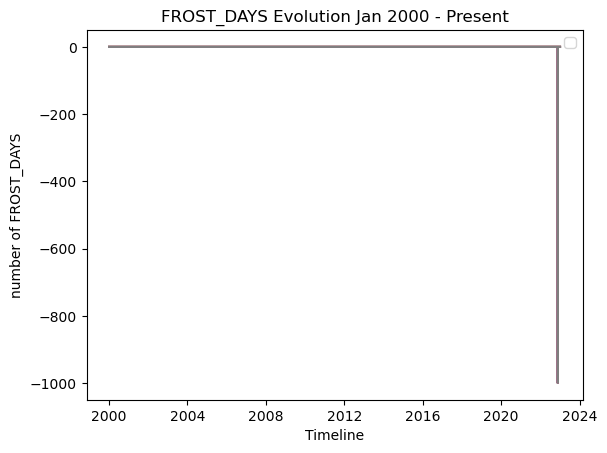

In [45]:
for column in weather_data.columns[1:]:
    if 'FROST_DAYS' in column:
        plt.plot(weather_data['date'],weather_data[column])
plt.xlabel('Timeline')
plt.ylabel('number of FROST_DAYS')
plt.legend()
plt.title('FROST_DAYS Evolution Jan 2000 - Present')
plt.show()

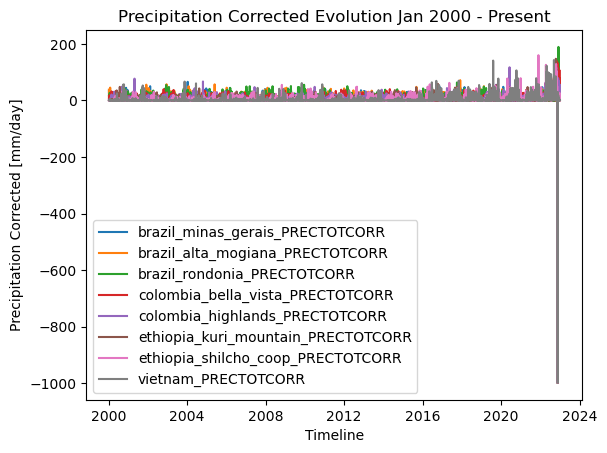

In [46]:
for column in weather_data.columns[1:]:
    if 'PRECTOTCORR' in column:
        plt.plot(weather_data['date'],weather_data[column],label=column)
plt.xlabel('Timeline')
plt.ylabel('Precipitation Corrected [mm/day]')
plt.legend()
plt.title('Precipitation Corrected Evolution Jan 2000 - Present')
plt.show()

We can see from the plot, that the FROST_DAYS does not seem to have any relevant information for us. It's either "0" or at the end "-999", which seems to be an error in the data collection. There is no reason to include this further in our dataset.

In [47]:
col_to_drop = []
for col in weather_data.columns:
    if 'FROST_DAYS' in col:
        col_to_drop.append(col)

In [48]:
weather_data = weather_data.drop(columns = col_to_drop, axis=1)

In [49]:
weather_data.head()

date  brazil_minas_gerais_PRECTOTCORR  \
0 2000-01-04                            34.03   
1 2000-01-05                             7.35   
2 2000-01-06                            10.98   
3 2000-01-07                             1.60   
4 2000-01-08                             1.06   

   brazil_alta_mogiana_PRECTOTCORR  brazil_rondonia_PRECTOTCORR  \
0                            38.22                        15.80   
1                            10.19                        12.67   
2                             5.65                         2.39   
3                             6.96                         8.44   
4                             1.08                         5.16   

   colombia_bella_vista_PRECTOTCORR  colombia_highlands_PRECTOTCORR  \
0                              7.27                            2.52   
1                             13.92                            0.71   
2                             10.35                            0.74   
3                              7.77                            1.60   
4                              4.88                            0.80   

   ethiopia_kuri_mountain_PRECTOTCORR  ethiopia_shilcho_coop_PRECTOTCORR  \
0                                0.27                                0.0   
1                                0.17                                0.0   
2                                0.01                                0.0   
3                                0.05                                0.0   
4                                0.36                                0.0   

   vietnam_PRECTOTCORR  
0                 0.20  
1                 0.00  
2                 0.04  
3                 0.21  
4                 0.00

In [50]:
for l in range(len(locations)):
    weather_data[locations[l][0]+'_latitude'] = locations[l][1]
    weather_data[locations[l][0]+'_longitude'] = locations[l][2]

In [51]:
weather_data.head()

date  brazil_minas_gerais_PRECTOTCORR  \
0 2000-01-04                            34.03   
1 2000-01-05                             7.35   
2 2000-01-06                            10.98   
3 2000-01-07                             1.60   
4 2000-01-08                             1.06   

   brazil_alta_mogiana_PRECTOTCORR  brazil_rondonia_PRECTOTCORR  \
0                            38.22                        15.80   
1                            10.19                        12.67   
2                             5.65                         2.39   
3                             6.96                         8.44   
4                             1.08                         5.16   

   colombia_bella_vista_PRECTOTCORR  colombia_highlands_PRECTOTCORR  \
0                              7.27                            2.52   
1                             13.92                            0.71   
2                             10.35                            0.74   
3                              7.77                            1.60   
4                              4.88                            0.80   

   ethiopia_kuri_mountain_PRECTOTCORR  ethiopia_shilcho_coop_PRECTOTCORR  \
0                                0.27                                0.0   
1                                0.17                                0.0   
2                                0.01                                0.0   
3                                0.05                                0.0   
4                                0.36                                0.0   

   vietnam_PRECTOTCORR brazil_minas_gerais_latitude  ...  \
0                 0.20           -20.99381692482433  ...   
1                 0.00           -20.99381692482433  ...   
2                 0.04           -20.99381692482433  ...   
3                 0.21           -20.99381692482433  ...   
4                 0.00           -20.99381692482433  ...   

  colombia_bella_vista_latitude colombia_bella_vista_longitude  \
0             4.439678121124939             -75.81569291434761   
1             4.439678121124939             -75.81569291434761   
2             4.439678121124939             -75.81569291434761   
3             4.439678121124939             -75.81569291434761   
4             4.439678121124939             -75.81569291434761   

  colombia_highlands_latitude colombia_highlands_longitude  \
0           5.674896883020882            -73.4710397381943   
1           5.674896883020882            -73.4710397381943   
2           5.674896883020882            -73.4710397381943   
3           5.674896883020882            -73.4710397381943   
4           5.674896883020882            -73.4710397381943   

  ethiopia_kuri_mountain_latitude ethiopia_kuri_mountain_longitude  \
0               8.993191517998033               34.601556339696764   
1               8.993191517998033               34.601556339696764   
2               8.993191517998033               34.601556339696764   
3               8.993191517998033               34.601556339696764   
4               8.993191517998033               34.601556339696764   

  ethiopia_shilcho_coop_latitude ethiopia_shilcho_coop_longitude  \
0              6.489290766609294               38.38969597625702   
1              6.489290766609294               38.38969597625702   
2              6.489290766609294               38.38969597625702   
3              6.489290766609294               38.38969597625702   
4              6.489290766609294               38.38969597625702   

     vietnam_latitude   vietnam_longitude  
0  12.766856113119104  108.00508881051391  
1  12.766856113119104  108.00508881051391  
2  12.766856113119104  108.00508881051391  
3  12.766856113119104  108.00508881051391  
4  12.766856113119104  108.00508881051391  

[5 rows x 25 columns]

### Get Data - Supply: Country Production (ICO)

- Source: https://www.ico.org/new_historical.asp
- Data Type: Excel, PDF
- Range: 1990 - 2019 (+2020 in PDF) 
- Data precision: yearly
- Data Information: Production [thousand 60kg-bags]

In [99]:
total_production = pd.read_excel('./Collected_Datasets/1a - Total production.xlsx', header=3)

In [100]:
display(total_production.shape)
total_production

(64, 32)

Crop year Unnamed: 1     1990/91      1991/92  \
0                                   NaN        NaN         NaN          NaN   
1                           April group        NaN  40795.2926   42529.5454   
2                                Angola      (R/A)     50.3450      79.3310   
3      Bolivia (Plurinational State of)        (A)    122.7770     103.5360   
4                                Brazil      (A/R)  27285.6286   27293.4934   
..                                  ...        ...         ...          ...   
59                             Viet Nam      (R/A)   1310.2880    1437.8480   
60                                Yemen        (A)      0.0000       0.0000   
61                                  NaN        NaN         NaN          NaN   
62                                Total        NaN  93230.0596  101266.6844   
63  © International Coffee Organization        NaN         NaN          NaN   

       1992/93     1993/94     1994/95     1995/96      1996/97     1997/98  \
0          NaN         NaN         NaN         NaN          NaN         NaN   
1   46868.2042  40166.7591  39990.3663  29395.9601   44297.8201  39475.8391   
2      77.5200     32.6080     76.8020     62.1090      70.9250     64.3300   
3     120.2350     50.8230    116.9440    142.4850     124.5790    140.7190   
4   34603.3542  28166.9786  28192.0470  18060.2022   29196.7430  26148.0040   
..         ...         ...         ...         ...          ...         ...   
59   2340.4470   3020.2160   3631.6090   3970.0860    5752.4810   6978.9420   
60      0.0000      0.0000      0.0000      0.0000       0.0000      0.0000   
61         NaN         NaN         NaN         NaN          NaN         NaN   
62  98524.0942  91761.0531  93313.7693  87320.8691  103307.8761  99887.1611   
63         NaN         NaN         NaN         NaN          NaN         NaN   

    ...      2010/11      2011/12      2012/13      2013/14      2014/15  \
0   ...          NaN          NaN          NaN          NaN          NaN   
1   ...   71811.3709   64395.2131   75895.8810   74494.0133   69873.1443   
2   ...      34.9700      28.7150      32.7900      34.9350      39.4050   
3   ...     117.2249     131.8354     105.2812     119.9122      99.8766   
4   ...   55428.4102   48591.8289   55418.0012   54688.9664   53304.7669   
..  ...          ...          ...          ...          ...          ...   
59  ...   19999.9999   26499.6111   23402.1057   27609.7814   27240.5219   
60  ...     161.1675     185.0677     187.5251     187.2981     178.3814   
61  ...          NaN          NaN          NaN          NaN          NaN   
62  ...  140077.5378  141327.3877  151183.5121  153910.3398  150301.6726   
63  ...          NaN          NaN          NaN          NaN          NaN   

        2015/16      2016/17      2017/18      2018/19      2019/20  
0           NaN          NaN          NaN          NaN          NaN  
1    71331.7881   75507.8515   70324.4647   81707.9885   76075.7437  
2       40.5150      44.8300      35.0060      41.9027      51.8419  
3       84.2191      77.9835      83.8112      82.5687      81.2654  
4    52870.5876   56788.1784   52739.8179   65130.7997   58210.7127  
..          ...          ...          ...          ...          ...  
59   31090.0419   27819.1762   33432.4990   30283.0748   30487.1644  
60     156.2460     143.4533     132.1281      85.5762      91.4278  
61          NaN          NaN          NaN          NaN          NaN  
62  156126.4745  162319.9801  163693.1027  172460.8203  165053.0157  
63          NaN          NaN          NaN          NaN          NaN  

[64 rows x 32 columns]

In [101]:
# Function to clean excel-data:

def clean_excel(df):
    #drop rows with too many NaN-Values and last one (ICO - copyright)
    df = df.dropna(axis=0, how='all').drop(df.tail(1).index)
    # dropping useless columns:
    df = df.drop(columns= ['Unnamed: 1'], axis=1)
    # set_index, transpose the dataset, reset_index, 
    df = df.set_index('Crop year').T.reset_index()
    # standardize header names
    df.columns = [e.lower().replace(' ', '_') for e in df.columns]
    df = df.rename(columns = {'index': 'crop_year'})
    #convert crop_year into datetime, year information
    df['crop_year'] = df['crop_year'].str.split("/").str[0]
    df['crop_year'] = pd.to_datetime(df['crop_year'], format='%Y').dt.year
    return df


In [102]:
total_production = clean_excel(total_production)
total_production.head()

crop_year  april_group  angola  bolivia_(plurinational_state_of)  \
0       1990   40795.2926  50.345                           122.777   
1       1991   42529.5454  79.331                           103.536   
2       1992   46868.2042  77.520                           120.235   
3       1993   40166.7591  32.608                            50.823   
4       1994   39990.3663  76.802                           116.944   

       brazil  burundi   ecuador  indonesia  madagascar   malawi  ...  \
0  27285.6286  487.393  1503.815   7441.383     982.447  104.628  ...   
1  27293.4934  667.199  2123.824   8493.196     932.513  124.286  ...   
2  34603.3542  620.238  1185.480   5569.478    1121.684  137.161  ...   
3  28166.9786  393.354  2069.007   6743.288     441.859   62.111  ...   
4  28192.0470  664.143  2375.766   5367.878     641.372   84.112  ...   

   sierra_leone  sri_lanka  thailand     togo  trinidad_&_tobago    uganda  \
0        42.783     95.870   757.017  161.308             14.581  1955.009   
1        54.379     81.549  1468.936  432.652             17.792  2088.001   
2        39.084     53.181  1254.945   85.648             14.328  2185.074   
3        37.451     53.790  1275.201  194.939             16.079  3141.706   
4        72.738     42.448  1399.135  176.296             18.435  2392.753   

   venezuela  viet_nam  yemen        total  
0   1122.477  1310.288    0.0   93230.0596  
1    940.704  1437.848    0.0  101266.6844  
2   1215.298  2340.447    0.0   98524.0942  
3   1332.881  3020.216    0.0   91761.0531  
4    988.996  3631.609    0.0   93313.7693  

[5 rows x 60 columns]

In [103]:
top_countries_list = ['brazil', 'viet_nam', 'colombia', 'indonesia', 'ethiopia']

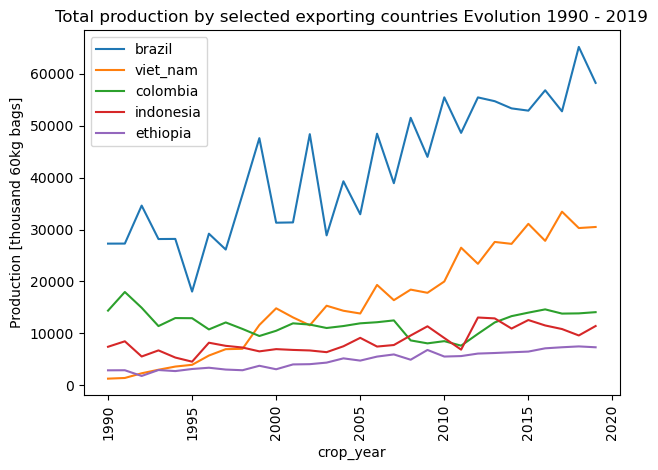

In [104]:
for country in top_countries_list:
    plt.plot(total_production['crop_year'],total_production[country],label=country)

plt.xlabel('crop_year')
plt.ylabel('Production [thousand 60kg bags]')
plt.title('Total production by selected exporting countries Evolution 1990 - 2019')
plt.legend()
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

Save .csv file for visualization with tableau:

In [105]:
# save production for all countries
total_production.to_csv('total_production.csv', index=False)

In [106]:
# save production for all countries with geographical location of country for visualization purpose.
total_production_visualization = total_production
total_production_visualization.columns= [e.replace('_', ' ') for e in total_production_visualization.columns]
total_production_visualization = total_production_visualization.set_index('crop year').T.reset_index()

#save for visualizations:
total_production_visualization.to_csv('total_production_visualization.csv', index=False)

In [107]:
## Harvest periods for top 10 countries:

# https://nordicapproach.no/wp-content/uploads/2022/08/coffee-calendar-web-withKE-1.png
# https://thecaptainscoffee.com/pages/coffee-harvest-seasons-and-availability

#months: 1 = jan, 2 = feb, 3= mar, etc.

harvest_period = {'brazil': [5, 6, 7, 8],
                'viet nam': [9,10,11,12,1],
                'colombia': [3,4,5,6,9,10,11,12],
                'indonesia': [5,6,7,8],
                'ethiopia': [10,11,12,1],
                'honduras': [1,2,3,4],
                'india': [1,2,3],
                'uganda': [5,6,7,8,9,10,11,12,1,2],
                'mexico': [11,12,1,2,3],
                'guatemala': [11,12,1,2,3]}


- Assumption 1: every year has 360 days and every month has 30 days.
- Assumption 2: crop_year = calendar_year.
- "daily production" = "production per year" divided by amount of "harvest_months" and then by 30 days.
- "daily production" is distributed only on the days of the harvest_months. The other months have a "daily production" of 0.

In [108]:
top_countries_list = ['brazil', 'viet nam', 'colombia', 'indonesia', 'ethiopia']

In [109]:
production_top_countries = total_production[top_countries_list]
production_top_countries['crop year'] = total_production['crop year']
production_top_countries.head()

brazil  viet nam   colombia  indonesia  ethiopia  crop year
0  27285.6286  1310.288  14396.000   7441.383  2909.451       1990
1  27293.4934  1437.848  17980.397   8493.196  2924.664       1991
2  34603.3542  2340.447  14946.878   5569.478  1825.171       1992
3  28166.9786  3020.216  11422.422   6743.288  2967.004       1993
4  28192.0470  3631.609  12964.000   5367.878  2762.730       1994

In [110]:
# we have some information for the year 2020 as well from the pdf.
production_top_countries_2020 = pd.DataFrame({'brazil': 69000.00, 'viet nam': 29000.00, 'colombia':14300.00, 'indonesia': 12100.00, 'ethiopia': 7375.00, 'crop year':2020}, index=["blabla"])
production_top_countries = production_top_countries.append(production_top_countries_2020, ignore_index=True)
production_top_countries.tail()

brazil    viet nam    colombia   indonesia   ethiopia  crop year
26  56788.1784  27819.1762  14634.3893  11541.0266  7142.9796       2016
27  52739.8179  33432.4990  13824.0725  10852.3153  7346.7332       2017
28  65130.7997  30283.0748  13865.9620   9617.5942  7511.2234       2018
29  58210.7127  30487.1644  14100.1182  11432.9425  7343.4329       2019
30  69000.0000  29000.0000  14300.0000  12100.0000  7375.0000       2020

In [111]:
years = list(range(2000,2023,1))

In [112]:
production_top_countries_00_20 = production_top_countries[production_top_countries['crop year'].isin(years)]
production_top_countries_00_20

brazil    viet nam    colombia   indonesia   ethiopia  crop year
10  31310.3530  14841.3090  10519.3520   6987.2397  3115.1490       2000
11  31365.0955  13093.2440  11950.2830   6833.3560  4044.2400       2001
12  48351.6340  11573.9350  11712.0400   6731.3760  4093.9020       2002
13  28873.4093  15337.3520  11052.6240   6404.0760  4393.7170       2003
14  39281.1457  14370.4530  11428.8560   7536.3710  5212.9510       2004
15  32932.9797  13841.8363  11952.2997   9158.9594  4779.4860       2005
16  48431.7338  19339.7501  12164.1926   7482.6737  5550.7400       2006
17  38911.4571  16405.0988  12515.0974   7776.5557  5966.6796       2007
18  51490.5177  18438.1201   8664.2903   9612.3466  4948.9869       2008
19  43976.8120  17825.3453   8097.5861  11379.6699  6830.1990       2009
20  55428.4102  19999.9999   8522.6594   9128.5118  5560.3848       2010
21  48591.8289  26499.6111   7653.3336   6888.9233  5650.4099       2011
22  55418.0012  23402.1057   9926.9445  13070.0386  6132.0066       2012
23  54688.9664  27609.7814  12124.0702  12900.9493  6242.4439       2013
24  53304.7669  27240.5219  13333.3435  10946.2773  6383.2618       2014
25  52870.5876  31090.0419  14008.7814  12585.4751  6514.9754       2015
26  56788.1784  27819.1762  14634.3893  11541.0266  7142.9796       2016
27  52739.8179  33432.4990  13824.0725  10852.3153  7346.7332       2017
28  65130.7997  30283.0748  13865.9620   9617.5942  7511.2234       2018
29  58210.7127  30487.1644  14100.1182  11432.9425  7343.4329       2019
30  69000.0000  29000.0000  14300.0000  12100.0000  7375.0000       2020

In [113]:
# Calculate new daily values: yearly_production / harvest_months / 30 days in a month
for country in top_countries_list:
    production_top_countries_00_20[country] = production_top_countries_00_20[country] / len(harvest_period[country])/30
production_top_countries_00_20.head()

brazil    viet nam   colombia  indonesia   ethiopia  crop year
10  260.919608   98.942060  43.830633  58.226998  25.959575       2000
11  261.375796   87.288293  49.792846  56.944633  33.702000       2001
12  402.930283   77.159567  48.800167  56.094800  34.115850       2002
13  240.611744  102.249013  46.052600  53.367300  36.614308       2003
14  327.342881   95.803020  47.620233  62.803092  43.441258       2004

In [114]:
production_top_countries_00_20['crop year'] = pd.to_datetime(production_top_countries_00_20['crop year'], format='%Y')
production_top_countries_00_20 =production_top_countries_00_20.rename(columns={'crop year':'date'})

In [115]:
production_top_countries_00_20.tail()

brazil    viet nam   colombia   indonesia   ethiopia       date
26  473.234820  185.461175  60.976622   96.175222  59.524830 2016-01-01
27  439.498483  222.883327  57.600302   90.435961  61.222777 2017-01-01
28  542.756664  201.887165  57.774842   80.146618  62.593528 2018-01-01
29  485.089272  203.247763  58.750493   95.274521  61.195274 2019-01-01
30  575.000000  193.333333  59.583333  100.833333  61.458333 2020-01-01

In [116]:
daily_prod_top_ten_countries_00_20 = upsample(production_top_countries_00_20,'2020-01-01','2021-01-01')

In [117]:
daily_prod_top_ten_countries_00_20.head()

date      brazil  viet nam   colombia  indonesia   ethiopia
0 2000-01-01  260.919608  98.94206  43.830633  58.226998  25.959575
1 2000-01-02  260.919608  98.94206  43.830633  58.226998  25.959575
2 2000-01-03  260.919608  98.94206  43.830633  58.226998  25.959575
3 2000-01-04  260.919608  98.94206  43.830633  58.226998  25.959575
4 2000-01-05  260.919608  98.94206  43.830633  58.226998  25.959575

In [118]:
harvest_df = pd.DataFrame()
harvest_df['date'] = daily_prod_top_ten_countries_00_20.date
harvest_df['month'] = harvest_df['date'].dt.month

In [119]:
for country in daily_prod_top_ten_countries_00_20.columns[1:11]:
    harvest_df[country] = np.where(harvest_df['month'].isin(harvest_period[country]),1,0)

harvest_df.tail()

date  month  brazil  viet nam  colombia  indonesia  ethiopia
7666 2020-12-27     12       0         1         1          0         1
7667 2020-12-28     12       0         1         1          0         1
7668 2020-12-29     12       0         1         1          0         1
7669 2020-12-30     12       0         1         1          0         1
7670 2020-12-31     12       0         1         1          0         1

In [120]:
display(harvest_df.shape)
display(daily_prod_top_ten_countries_00_20.shape)

(7671, 7)

(7671, 6)

In [121]:
prod_top_ten_00_20_harvest = harvest_df[top_countries_list].mul(daily_prod_top_ten_countries_00_20[top_countries_list], fill_value=0)

In [122]:
prod_top_ten_00_20_harvest['date'] = harvest_df['date']

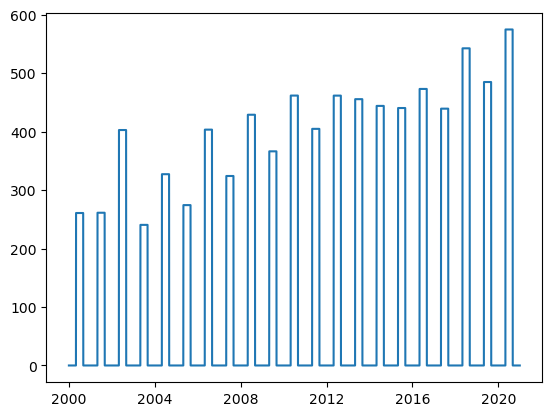

In [123]:
plt.plot(prod_top_ten_00_20_harvest.date, prod_top_ten_00_20_harvest.brazil)

In [124]:
#rename column names for merging later.
prod_top_ten_00_20_harvest=prod_top_ten_00_20_harvest.add_suffix('_production')
prod_top_ten_00_20_harvest=prod_top_ten_00_20_harvest.rename(columns={'date_production':'date'})

Final Data for the Merge:

In [125]:
prod_top_ten_00_20_harvest.brazil_production.unique()

array([0.0, 260.9196083333333, 261.3757958333333, 402.9302833333333,
       240.61174416666665, 327.34288083333337, 274.4414975,
       403.59778166666666, 324.2621425, 429.08764749999995,
       366.47343333333333, 461.9034183333333, 404.9319075,
       461.81667666666664, 455.74138666666664, 444.20639083333333,
       440.58823, 473.23481999999996, 439.4984825, 542.7566641666667,
       485.0892725, 575.0], dtype=object)

In [126]:
prod_top_ten_00_20_harvest.tail(5)

brazil_production viet nam_production colombia_production  \
7666               0.0          193.333333           59.583333   
7667               0.0          193.333333           59.583333   
7668               0.0          193.333333           59.583333   
7669               0.0          193.333333           59.583333   
7670               0.0          193.333333           59.583333   

     indonesia_production ethiopia_production       date  
7666                  0.0           61.458333 2020-12-27  
7667                  0.0           61.458333 2020-12-28  
7668                  0.0           61.458333 2020-12-29  
7669                  0.0           61.458333 2020-12-30  
7670                  0.0           61.458333 2020-12-31

### Get Data - Demand: Imports (ICO)

- Source: https://www.ico.org/new_historical.asp
- Data Type: Excel, PDF
- Range: 1990 - 2019 (+2020, 2021 in PDF) 
- Data precision: yearly
- Data Information: Imports [thousand 60kg-bags]

In [127]:
imports = pd.read_excel('./Collected_Datasets/2b - Imports.xlsx', header=3)

In [128]:
display(imports.shape)
imports

(41, 31)

Calendar years          1990          1991  \
0                                   NaN           NaN           NaN   
1                        European Union  42882.776087  41143.872116   
2                               Austria   1879.717004   2058.271005   
3                               Belgium           NaN           NaN   
4                    Belgium/Luxembourg   2014.954017   1746.225019   
5                              Bulgaria    268.182998    200.220001   
6                               Croatia           NaN           NaN   
7                                Cyprus     49.853999     53.926000   
8                               Czechia    659.433000    525.274000   
9                               Denmark    959.105004    982.757004   
10                              Estonia           NaN           NaN   
11                              Finland   1095.140998   1033.066999   
12                               France   6301.221035   6552.709041   
13                              Germany  13670.946005  13228.851004   
14                               Greece    641.963000    407.027001   
15                              Hungary    573.974000    640.987003   
16                              Ireland    129.477001    118.267001   
17                                Italy   5241.831000   4630.023000   
18                               Latvia           NaN           NaN   
19                            Lithuania           NaN           NaN   
20                           Luxembourg           NaN           NaN   
21                                Malta     20.713999     16.074003   
22                          Netherlands   3128.150018   3120.774019   
23                               Poland    435.065001    249.871003   
24                             Portugal    551.589001    557.469001   
25                              Romania    441.534003    335.450012   
26                             Slovakia      0.000000      0.000000   
27                             Slovenia      0.000000      0.000000   
28                                Spain   3053.251000   2969.543000   
29                               Sweden   1766.674003   1717.087000   
30                                  NaN           NaN           NaN   
31                                Japan   5329.750004   5510.469001   
32                               Norway    742.040002    761.214999   
33                   Russian Federation      0.000000      0.000000   
34                          Switzerland   1170.508002   1130.292002   
35                              Tunisia    100.999998     90.201001   
36                       United Kingdom   2898.298008   2805.914005   
37             United States of America  21006.786010  19839.630013   
38                                  NaN           NaN           NaN   
39                                Total  74131.158111  71281.593136   
40  © International Coffee Organization           NaN           NaN   

            1992          1993          1994          1995          1996  \
0            NaN           NaN           NaN           NaN           NaN   
1   44529.994175  45254.467632  45402.131489  43424.386494  46408.406787   
2    2206.416005   1836.489002   1417.214004   1231.436001   1210.466006   
3            NaN           NaN           NaN           NaN           NaN   
4    1827.851020   2063.260029   2262.473036   2401.498025   2525.823622   
5     182.231012    397.443006    462.668007    515.418008    272.159995   
6     168.190005    162.774001    193.450002    320.132006    321.835998   
7      40.875999     77.412000     51.836001     43.769000     51.501999   
8     474.731003    514.277005    553.797003    553.196999    525.298002   
9    1061.623004    993.947000   1033.184003    877.159002   1005.999200   
10     16.378000     51.147998     83.097998    107.478002    116.918007   
11   1055.361000   1301.455999   1361.003002    769.499000    992.273602   
12   6612.056041   6334.468044   6368.662042   6213.68

In [129]:
# Function to clean excel-data:

def clean_import_excel(df):
    #drop rows with too many NaN-Values and last one (ICO - copyright)
    df = df.dropna(axis=0)#, how='all')#.drop(df.tail(1).index)
    # dropping useless columns:
    #df = df.drop(columns= ['Unnamed: 1'], axis=1)
    # set_index, transpose the dataset, reset_index, 
    df = df.set_index('Calendar years').T.reset_index()
    # standardize header names
    df.columns = [e.lower().replace(' ', '_') for e in df.columns]
    df = df.rename(columns = {'index': 'calendar_year'})
    #convert crop_year into datetime, year information
    df['calendar_year'] = df['calendar_year'].str.split("/").str[0]
    df['calendar_year'] = pd.to_datetime(df['calendar_year'], format='%Y').dt.year
    return df


In [130]:
imports = clean_import_excel(imports)
imports.head()

calendar_year  european_union   ___austria  ___bulgaria  ___cyprus  \
0           1990    42882.776087  1879.717004   268.182998  49.853999   
1           1991    41143.872116  2058.271005   200.220001  53.926000   
2           1992    44529.994175  2206.416005   182.231012  40.875999   
3           1993    45254.467632  1836.489002   397.443006  77.412000   
4           1994    45402.131489  1417.214004   462.668007  51.836001   

   ___czechia   ___denmark   ___finland    ___france    ___germany  ...  \
0  659.433000   959.105004  1095.140998  6301.221035  13670.946005  ...   
1  525.274000   982.757004  1033.066999  6552.709041  13228.851004  ...   
2  474.731003  1061.623004  1055.361000  6612.056041  13788.554006  ...   
3  514.277005   993.947000  1301.455999  6334.468044  14107.003006  ...   
4  553.797003  1033.184003  1361.003002  6368.662042  13583.215008  ...   

      ___spain    ___sweden        japan      norway  russian_federation  \
0  3053.251000  1766.674003  5329.750004  742.040002            0.000000   
1  2969.543000  1717.087000  5510.469001  761.214999            0.000000   
2  3414.290003  1771.725002  5325.615998  739.145001         1381.858008   
3  2813.088000  1756.601007  5691.120004  692.829002         1794.946013   
4  3028.425000  1893.292008  6217.151005  805.628000         1725.730019   

   switzerland     tunisia  united_kingdom  united_states_of_america  \
0  1170.508002  100.999998     2898.298008              21006.786010   
1  1130.292002   90.201001     2805.914005              19839.630013   
2  1101.251002  110.583001     3088.172009              22939.033012   
3  1059.878001  100.624001     3196.981011              19328.721012   
4  1099.406002  137.267000     3465.860012              16171.245016   

          total  
0  74131.158111  
1  71281.593136  
2  79215.652205  
3  77119.566676  
4  75024.418544  

[5 rows x 31 columns]

Save .csv file for visualization with tableau:

In [131]:
#save intermediate results for visualization:
imports_viz = imports
imports_viz.to_csv('imports.csv', index=False)

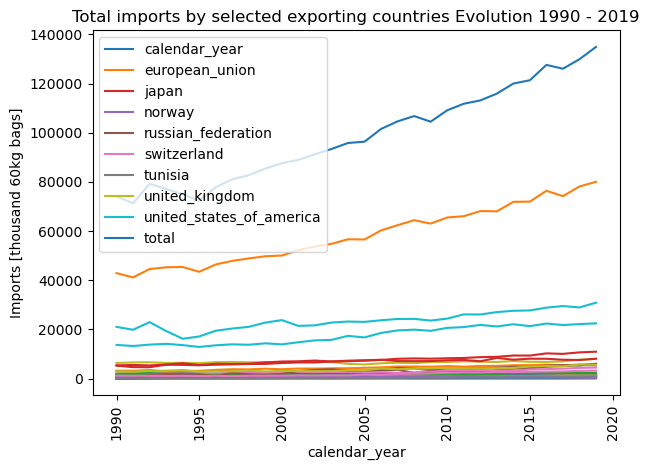

In [132]:
for country in imports.columns: #top_countries_list:
    plt.plot(imports['calendar_year'],imports[country],label=country)

plt.xlabel('calendar_year')
plt.ylabel('Imports [thousand 60kg bags]')
plt.title('Total imports by selected exporting countries Evolution 1990 - 2019')
plt.legend()
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [133]:
# We will focus only on the european_union and the united_states_of_america:
country_import_list = ['european_union', 'united_states_of_america']

In [134]:
import_top_countries = imports[country_import_list]
import_top_countries['calendar_year'] = imports['calendar_year']
import_top_countries.tail()

european_union  united_states_of_america  calendar_year
25    71995.027768              27707.663702           2015
26    76402.459294              28837.837837           2016
27    74221.374859              29487.886464           2017
28    78151.221303              28918.207055           2018
29    80057.043941              30854.072649           2019

In [135]:
# We have Information for the years 2020 and 2021 as PDF as well, let's add them.
import_top_countries_2020 = pd.DataFrame({'european_union': 77430.547, 'united_states_of_america': 28371.674, 'calendar_year':2020}, index=["blabla"])
import_top_countries_2021 = pd.DataFrame({'european_union': 79428.544, 'united_states_of_america': 29242.559, 'calendar_year':2021}, index=["blabla"])

In [136]:
import_top_countries = import_top_countries.append(import_top_countries_2020, ignore_index=True)
import_top_countries = import_top_countries.append(import_top_countries_2021, ignore_index=True)
import_top_countries.tail()

european_union  united_states_of_america  calendar_year
27    74221.374859              29487.886464           2017
28    78151.221303              28918.207055           2018
29    80057.043941              30854.072649           2019
30    77430.547000              28371.674000           2020
31    79428.544000              29242.559000           2021

In [137]:
# only 2000 - 2021
import_top_countries_00_21 = import_top_countries[import_top_countries['calendar_year'].isin(years)]
import_top_countries_00_21.tail()

european_union  united_states_of_america  calendar_year
27    74221.374859              29487.886464           2017
28    78151.221303              28918.207055           2018
29    80057.043941              30854.072649           2019
30    77430.547000              28371.674000           2020
31    79428.544000              29242.559000           2021

In [138]:
#convert date into datetime, year information
import_top_countries_00_21['calendar_year'] = pd.to_datetime(import_top_countries_00_21['calendar_year'], format='%Y')
import_top_countries_00_21 = import_top_countries_00_21.rename(columns = {'calendar_year': 'date'})
import_top_countries_00_21.tail()

european_union  united_states_of_america       date
27    74221.374859              29487.886464 2017-01-01
28    78151.221303              28918.207055 2018-01-01
29    80057.043941              30854.072649 2019-01-01
30    77430.547000              28371.674000 2020-01-01
31    79428.544000              29242.559000 2021-01-01

In [139]:
# calculate values per day by dividing the value by number of days per month = 30
for country in country_import_list:
    import_top_countries_00_21[country] = import_top_countries_00_21[country] / 360
import_top_countries_00_21.tail()

european_union  united_states_of_america       date
27      206.170486                 81.910796 2017-01-01
28      217.086726                 80.328353 2018-01-01
29      222.380678                 85.705757 2019-01-01
30      215.084853                 78.810206 2020-01-01
31      220.634844                 81.229331 2021-01-01

In [140]:
imports_top_countries_00_21_daily = upsample(import_top_countries_00_21,'2021-01-01','2022-01-01')

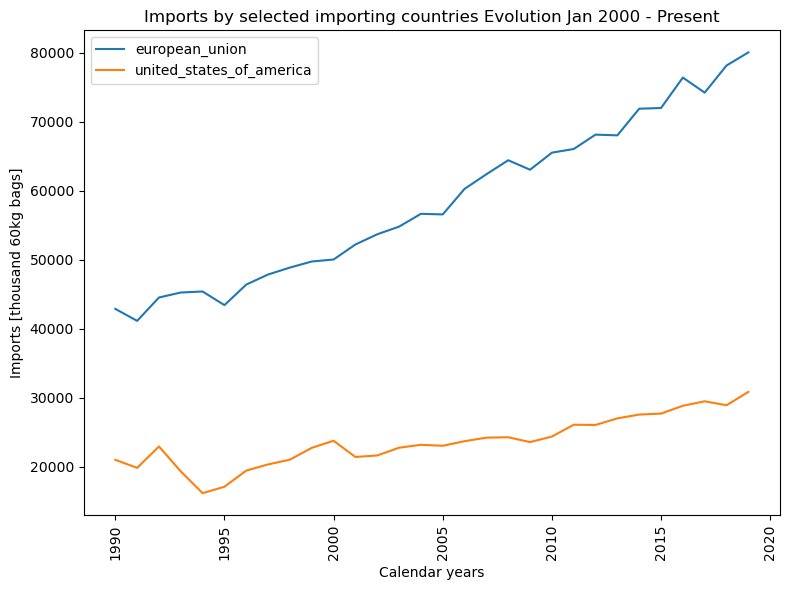

In [141]:
plt.figure(figsize=(8, 6))

for country in country_import_list:
    plt.plot(imports['calendar_year'],imports[country],label=country)

plt.xlabel('Calendar years')
plt.ylabel('Imports [thousand 60kg bags]')
plt.title('Imports by selected importing countries Evolution Jan 2000 - Present')
plt.legend()#loc='upper center', bbox_to_anchor=(0.5, 1.05),ncol=3, fancybox=True)
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

Final Data for the merge:

In [142]:
#rename column names for merging later.
imports_top_countries_00_21_daily = imports_top_countries_00_21_daily.add_suffix('_imports')
imports_top_countries_00_21_daily = imports_top_countries_00_21_daily.rename(columns={'date_imports':'date'})

### Get Data - Demand: Re-Exports

- Source: https://www.ico.org/new_historical.asp
- Data Type: Excel, PDF
- Range: 1990 - 2019 (+2020 in PDF) 
- Data precision: yearly
- Data Information: Re-Exports [thousand 60kg-bags]

In [143]:
re_exports = pd.read_excel('./Collected_Datasets/2c - Re-exports.xlsx', header=3)

In [144]:
display(re_exports.shape)
re_exports

(41, 31)

Calendar years         1990         1991  \
0                                   NaN          NaN          NaN   
1                        European Union  7267.770128  8085.310173   
2                               Austria   414.593018   756.185035   
3                               Belgium          NaN          NaN   
4                    Belgium/Luxembourg   890.844034  1038.068039   
5                              Bulgaria   166.400000   183.459000   
6                               Croatia          NaN          NaN   
7                                Cyprus    16.283000     7.229000   
8                               Czechia          NaN          NaN   
9                               Denmark    93.966004    74.215003   
10                              Estonia          NaN          NaN   
11                              Finland    18.706000    20.513000   
12                               France   912.582005  1006.871008   
13                              Germany  3291.689044  3251.635055   
14                               Greece    11.166996    20.084995   
15                              Hungary          NaN   260.759006   
16                              Ireland     9.592000     5.301000   
17                                Italy   382.537013   401.983016   
18                               Latvia          NaN          NaN   
19                            Lithuania          NaN          NaN   
20                           Luxembourg          NaN          NaN   
21                                Malta     1.101000     3.129001   
22                          Netherlands   585.397007   633.113008   
23                               Poland   100.473000     6.847001   
24                             Portugal    30.570001    34.080001   
25                              Romania          NaN     0.033000   
26                             Slovakia          NaN          NaN   
27                             Slovenia          NaN          NaN   
28                                Spain   264.538000   268.274999   
29                               Sweden    77.332003   113.530006   
30                                  NaN          NaN          NaN   
31                                Japan    19.901999    34.494999   
32                               Norway     8.376000     3.562000   
33                   Russian Federation          NaN          NaN   
34                          Switzerland   166.028998   151.402001   
35                              Tunisia          NaN          NaN   
36                       United Kingdom   482.210998   485.174001   
37             United States of America   825.168009  1010.450011   
38                                  NaN          NaN          NaN   
39                                Total  8769.456132  9770.393185   
40  © International Coffee Organization          NaN          NaN   

            1992          1993          1994          1995          1996  \
0            NaN           NaN           NaN           NaN           NaN   
1    8554.469193   8488.933823   9200.844923   8800.969466   9563.717875   
2     960.082041    535.488020    380.995008    228.666006    162.678005   
3            NaN           NaN           NaN           NaN           NaN   
4    1131.478041   1273.823045   1304.258046   1328.483041   1487.186551   
5       7.353000     70.488000    109.904001    122.010001     25.685000   
6      33.645001     30.884001     29.588001     31.651001     17.367000   
7       3.572000      1.896000      1.467000      1.091000      0.761000   
8       2.574998     65.882001     45.073003     41.743002     50.306000   
9     102.788005    103.391003    124.701001    119.362004    110.985203   
10      3.469000      6.958999     19.934003     24.629998     32.703996   
11     35.033001    197.592007    217.495008     96.821004    171.631707   
12   1022.620011    975.788007   1165.390005   1080.665003   1182.424108   
13   3318.152055   3282.270065   3469.270066   3220.384054   3

In [145]:
re_exports = clean_import_excel(re_exports)
re_exports.head()

calendar_year  european_union  ___austria  ___bulgaria  ___denmark  \
0           1990     7267.770128  414.593018   166.400000   93.966004   
1           1991     8085.310173  756.185035   183.459000   74.215003   
2           1992     8554.469193  960.082041     7.353000  102.788005   
3           1993     8488.933823  535.488020    70.488000  103.391003   
4           1994     9200.844923  380.995008   109.904001  124.701001   

   ___finland    ___france   ___germany   ___greece  ___ireland  ...  \
0   18.706000   912.582005  3291.689044   11.166996       9.592  ...   
1   20.513000  1006.871008  3251.635055   20.084995       5.301  ...   
2   35.033001  1022.620011  3318.152055   28.755999       3.839  ...   
3  197.592007   975.788007  3282.270065  226.872999       3.232  ...   
4  217.495008  1165.390005  3469.270066  145.841999       3.417  ...   

    ___poland  ___portugal    ___spain   ___sweden      japan  norway  \
0  100.473000    30.570001  264.538000   77.332003  19.901999   8.376   
1    6.847001    34.080001  268.274999  113.530006  34.494999   3.562   
2  136.828003    40.260001  286.611001  137.590006  27.183999   2.681   
3  125.782634    38.270001  168.477000  138.207006  34.283999   2.599   
4  100.477811    52.051000  237.236998  223.919007  27.118999   6.018   

   switzerland  united_kingdom  united_states_of_america         total  
0   166.028998      482.210998                825.168009   8769.456132  
1   151.402001      485.174001               1010.450011   9770.393185  
2   155.359998      570.164001               1376.580016  10691.139208  
3   166.086996      629.293000               1719.584016  11040.995834  
4   196.028998      817.122000               2572.141022  12832.797943  

[5 rows x 23 columns]

Save .csv file for visualization with tableau:

In [146]:
# save intermediate results for visualization:
re_exports_viz = re_exports
# re_exports_viz.to_csv('re_exports.csv', index=False)

In [147]:
#save intermediate results for visualization:
concat_import_re_export_viz = pd.concat([imports_viz, re_exports_viz],axis=1)
concat_import_re_export_viz.to_csv('concat_import_re_export_viz.csv', index=False)

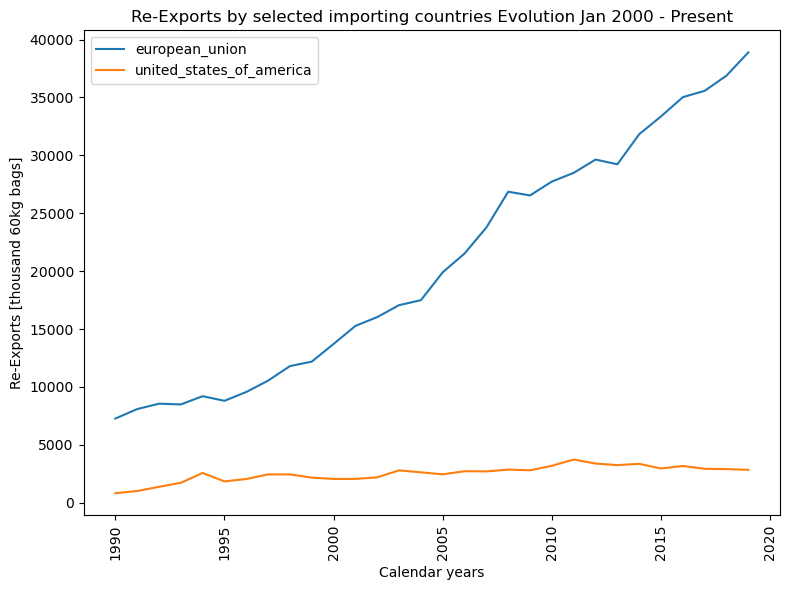

In [148]:
plt.figure(figsize=(8, 6))

for country in country_import_list:
    plt.plot(re_exports['calendar_year'],re_exports[country],label=country)

plt.xlabel('Calendar years')
plt.ylabel('Re-Exports [thousand 60kg bags]')
plt.title('Re-Exports by selected importing countries Evolution Jan 2000 - Present')
plt.legend()
plt.xticks(rotation = 90)
plt.tight_layout()
plt.show()

In [149]:
# We will focus only on the european_union and the united_states_of_america:
re_exports_top_countries = re_exports[country_import_list]
re_exports_top_countries['calendar_year'] = re_exports['calendar_year']
re_exports_top_countries.tail()

european_union  united_states_of_america  calendar_year
25    33362.979599               2958.179383           2015
26    35023.177113               3174.963717           2016
27    35568.918485               2929.672218           2017
28    36883.193547               2902.389651           2018
29    38889.768539               2842.417761           2019

In [150]:
# We have Information for the years 2020 and 2021 as PDF as well, let's add them.
re_exports_top_countries_2020 = pd.DataFrame({'european_union': 38332.487, 'united_states_of_america': 2576.850, 'calendar_year':2020}, index=["blabla"])
re_exports_top_countries_2021 = pd.DataFrame({'european_union': 40669.183, 'united_states_of_america': 3017.842, 'calendar_year':2021}, index=["blabla"])

In [151]:
re_exports_top_countries = re_exports_top_countries.append(re_exports_top_countries_2020, ignore_index=True)
re_exports_top_countries = re_exports_top_countries.append(re_exports_top_countries_2021, ignore_index=True)
re_exports_top_countries.tail()

european_union  united_states_of_america  calendar_year
27    35568.918485               2929.672218           2017
28    36883.193547               2902.389651           2018
29    38889.768539               2842.417761           2019
30    38332.487000               2576.850000           2020
31    40669.183000               3017.842000           2021

In [152]:
# only 2000 - 2021
re_exports_top_countries_00_21 = re_exports_top_countries[re_exports_top_countries['calendar_year'].isin(years)]
re_exports_top_countries_00_21.tail()

european_union  united_states_of_america  calendar_year
27    35568.918485               2929.672218           2017
28    36883.193547               2902.389651           2018
29    38889.768539               2842.417761           2019
30    38332.487000               2576.850000           2020
31    40669.183000               3017.842000           2021

In [153]:
#convert date into datetime, year information
re_exports_top_countries_00_21['calendar_year'] = pd.to_datetime(re_exports_top_countries_00_21['calendar_year'], format='%Y')
re_exports_top_countries_00_21 = re_exports_top_countries_00_21.rename(columns = {'calendar_year': 'date'})
re_exports_top_countries_00_21.tail()

european_union  united_states_of_america       date
27    35568.918485               2929.672218 2017-01-01
28    36883.193547               2902.389651 2018-01-01
29    38889.768539               2842.417761 2019-01-01
30    38332.487000               2576.850000 2020-01-01
31    40669.183000               3017.842000 2021-01-01

In [154]:
# calculate values per day by dividing the value by number of days per month = 30
for country in country_import_list:
    re_exports_top_countries_00_21[country] = re_exports_top_countries_00_21[country] / 360
re_exports_top_countries_00_21.tail()

european_union  united_states_of_america       date
27       98.802551                  8.137978 2017-01-01
28      102.453315                  8.062193 2018-01-01
29      108.027135                  7.895605 2019-01-01
30      106.479131                  7.157917 2020-01-01
31      112.969953                  8.382894 2021-01-01

In [155]:
re_exports_top_countries_00_21_daily = upsample(re_exports_top_countries_00_21,'2021-01-01','2022-01-01')

Final Data for the merge:

In [156]:
#rename column names for merging later.
re_exports_top_countries_00_21_daily = re_exports_top_countries_00_21_daily.add_suffix('_reexports')
re_exports_top_countries_00_21_daily = re_exports_top_countries_00_21_daily.rename(columns={'date_reexports':'date'})

### Get Data - Demand: Inflation OECD

- Source: https://data.oecd.org/price/inflation-cpi.htm#
- Data Type: .csv
- Range: defined at 2000 - 2022  
- Data precision: monthly
- Data Information: Annual Growth Rate [%]

In [157]:
OECD_inflation = pd.read_csv('./Collected_Datasets/OECD_inflation_onlyOECD_2000-2022.csv')

In [158]:
display(OECD_inflation.shape)
OECD_inflation.head()

(279, 8)

LOCATION INDICATOR SUBJECT MEASURE FREQUENCY     TIME     Value  Flag Codes
0     OECD       CPI     TOT  AGRWTH         M  1999-09  3.889684         NaN
1     OECD       CPI     TOT  AGRWTH         M  1999-10  3.796540         NaN
2     OECD       CPI     TOT  AGRWTH         M  1999-11  3.777679         NaN
3     OECD       CPI     TOT  AGRWTH         M  1999-12  3.912647         NaN
4     OECD       CPI     TOT  AGRWTH         M  2000-01  3.955080         NaN

In [159]:
def clean_OECD(df):
    # We are only interested in the Time and in the inflation rate.
    df = df[['TIME','Value']]
    # standardize header names
    df.columns = [e.lower().replace(' ', '') for e in df.columns]
    df = df.rename(columns = {'time': 'date','value':'inflation_rate'})

    #convert date into datetime, year information
    df['date'] = pd.to_datetime(df['date'], format='%Y-%m')
    return df


In [160]:
OECD_inflation = clean_OECD(OECD_inflation)
OECD_inflation.tail()

date  inflation_rate
274 2022-07-01        10.24300
275 2022-08-01        10.26059
276 2022-09-01        10.54856
277 2022-10-01        10.67563
278 2022-11-01        10.25446

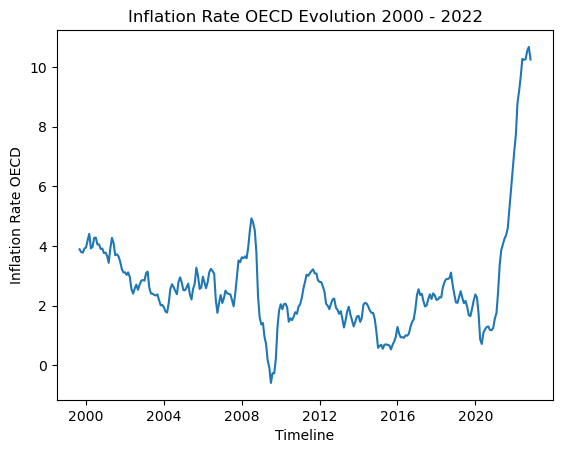

In [161]:
plt.plot(OECD_inflation['date'],OECD_inflation['inflation_rate'],label='inflation_rate')
plt.xlabel('Timeline')
plt.ylabel('Inflation Rate OECD')
plt.title('Inflation Rate OECD Evolution 2000 - 2022')
#plt.legend()
plt.show()

In [162]:
OECD_inflation_daily = upsample(OECD_inflation,'2022-11-01','2022-12-01')
OECD_inflation_daily.tail()

date inflation_rate
8487 2022-11-26       10.25446
8488 2022-11-27       10.25446
8489 2022-11-28       10.25446
8490 2022-11-29       10.25446
8491 2022-11-30       10.25446

### Get Data - Demand: Unemployment Rate EA19 (Euro Area 19 countries)

- Source: https://data.oecd.org/unemp/unemployment-rate.htm
- Data Type: .csv
- Range: defined at 2000 - 2022  
- Data precision: monthly
- Data Information: Unemployment Rate as % of labour force [%]

In [163]:
OECD_unemployment = pd.read_csv('./Collected_Datasets/OECD_unemployment_2000-2022.csv')

In [164]:
display(OECD_unemployment.shape)
OECD_unemployment.head()

(538, 8)

LOCATION INDICATOR SUBJECT MEASURE FREQUENCY     TIME     Value Flag Codes
0     OECD       HUR     TOT   PC_LF         M  2001-01  6.455023          E
1     OECD       HUR     TOT   PC_LF         M  2001-02  6.472813          E
2     OECD       HUR     TOT   PC_LF         M  2001-03  6.474783          E
3     OECD       HUR     TOT   PC_LF         M  2001-04  6.498424          E
4     OECD       HUR     TOT   PC_LF         M  2001-05  6.518929          E

In [165]:
# get only the information for the European Area (19 countries)
EA19_unemployment = OECD_unemployment[OECD_unemployment['LOCATION'] == 'EA19'].reset_index()
EA19_unemployment.head()

index LOCATION INDICATOR SUBJECT MEASURE FREQUENCY     TIME  Value  \
0    263     EA19       HUR     TOT   PC_LF         M  2000-01    9.4   
1    264     EA19       HUR     TOT   PC_LF         M  2000-02    9.3   
2    265     EA19       HUR     TOT   PC_LF         M  2000-03    9.2   
3    266     EA19       HUR     TOT   PC_LF         M  2000-04    9.1   
4    267     EA19       HUR     TOT   PC_LF         M  2000-05    9.0   

  Flag Codes  
0        NaN  
1        NaN  
2        NaN  
3        NaN  
4        NaN

In [166]:
EA19_unemployment = clean_OECD(EA19_unemployment)
EA19_unemployment = EA19_unemployment.rename(columns = {'inflation_rate':'unemployment_rate'})
EA19_unemployment.tail()

date  unemployment_rate
270 2022-07-01                6.6
271 2022-08-01                6.7
272 2022-09-01                6.6
273 2022-10-01                6.5
274 2022-11-01                6.5

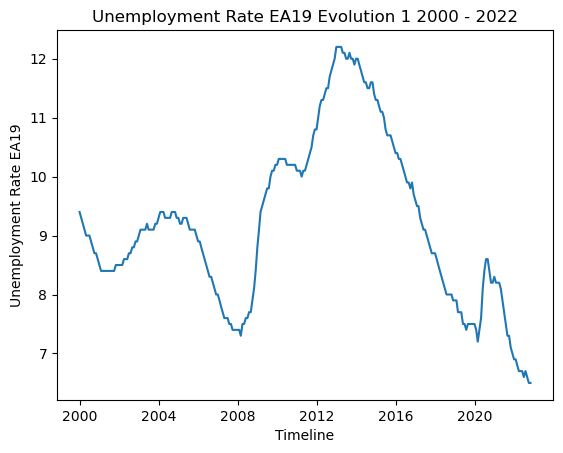

In [167]:
plt.plot(EA19_unemployment['date'],EA19_unemployment['unemployment_rate'],label='unemployment_rate')
plt.xlabel('Timeline')
plt.ylabel('Unemployment Rate EA19')
plt.title('Unemployment Rate EA19 Evolution 1 2000 - 2022')
#plt.legend()
plt.show()

In [168]:
EA19_unemployment_daily = upsample(EA19_unemployment,'2022-11-01','2022-12-01')
EA19_unemployment_daily.tail()

date unemployment_rate
8365 2022-11-26               6.5
8366 2022-11-27               6.5
8367 2022-11-28               6.5
8368 2022-11-29               6.5
8369 2022-11-30               6.5

### Get Data - Demand: Currency Exchange Rate EUR€/US$

- Source: https://de.finance.yahoo.com/quote/eurusd=x
- Data Type: yahoofinance python library
- Range: 01.12.2003 - 31.12.2022 
- Data precision: daily (when markets are open)
- Data Information: Currency Exchange Rate 1 Euro = X US$

In [169]:
yahoo_import_EUR_USD = yf.download('EURUSD=X', start="2000-01-04", end="2022-12-31")

[*********************100%***********************]  1 of 1 completed


In [170]:
data_currency_USD_EUR = yahoo_import_EUR_USD
display(data_currency_USD_EUR.shape)
data_currency_USD_EUR.head()

(4951, 6)

Open      High       Low     Close  Adj Close  \
Date                                                                           
2003-12-01 00:00:00+00:00  1.203398  1.204007  1.194401  1.196501   1.196501   
2003-12-02 00:00:00+00:00  1.196101  1.210903  1.194600  1.208897   1.208897   
2003-12-03 00:00:00+00:00  1.209000  1.213003  1.207700  1.212298   1.212298   
2003-12-04 00:00:00+00:00  1.212004  1.214403  1.204398  1.208094   1.208094   
2003-12-05 00:00:00+00:00  1.207802  1.219096  1.206593  1.218695   1.218695   

                           Volume  
Date                               
2003-12-01 00:00:00+00:00       0  
2003-12-02 00:00:00+00:00       0  
2003-12-03 00:00:00+00:00       0  
2003-12-04 00:00:00+00:00       0  
2003-12-05 00:00:00+00:00       0

In [171]:
data_currency_USD_EUR = clean_yahoo(data_currency_USD_EUR)
data_currency_USD_EUR.head()

date  volume  daily_average
0 2003-12-01       0       1.199950
1 2003-12-02       0       1.202499
2 2003-12-03       0       1.210649
3 2003-12-04       0       1.210049
4 2003-12-05       0       1.213249

In [172]:
#keep only date and daily_average rename column names for merging later.
data_currency_USD_EUR=data_currency_USD_EUR[['date','daily_average']]
data_currency_USD_EUR=data_currency_USD_EUR.rename(columns={'daily_average':'daily_exch_usd_eur'})

In [173]:
data_currency_USD_EUR.columns

Index(['date', 'daily_exch_usd_eur'], dtype='object')

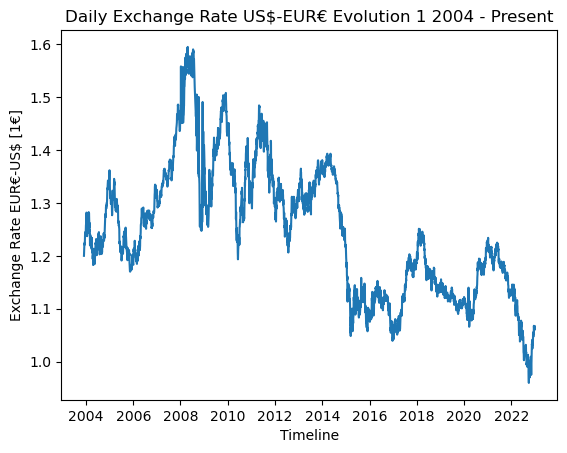

In [174]:
plt.plot(data_currency_USD_EUR.date,data_currency_USD_EUR.daily_exch_usd_eur)
plt.xlabel('Timeline')
plt.ylabel('Exchange Rate EUR€-US$ [1€]')
plt.title('Daily Exchange Rate US$-EUR€ Evolution 1 2004 - Present')
plt.show()

### Get Data - Demand: Growth Emerging Markets (GDP - China)

- Source: https://data.oecd.org/gdp/gross-domestic-product-gdp.htm
- Data Type: .csv
- Range: 2000 - 2021 
- Data precision: yearly
- Data Information: GDP [Million US$]

In [175]:
OECD_GDP_China = pd.read_csv('./Collected_Datasets/OECD_GDP_China_2000-2021.csv')

In [176]:
display(OECD_GDP_China.shape)
OECD_GDP_China.head()

(22, 8)

LOCATION INDICATOR SUBJECT  MEASURE FREQUENCY  TIME        Value  Flag Codes
0      CHN       GDP     TOT  MLN_USD         A  2000  3683440.252         NaN
1      CHN       GDP     TOT  MLN_USD         A  2001  4080386.422         NaN
2      CHN       GDP     TOT  MLN_USD         A  2002  4522476.428         NaN
3      CHN       GDP     TOT  MLN_USD         A  2003  5074658.797         NaN
4      CHN       GDP     TOT  MLN_USD         A  2004  5737895.201         NaN

In [177]:
def clean_OECD_GDP(df):
    # We are only interested in the Time and in the inflation rate.
    df = df[['TIME','Value']]
    # standardize header names
    df.columns = [e.lower().replace(' ', '') for e in df.columns]
    df = df.rename(columns = {'time': 'date','value':'gdp_china_mio_usd'})

    #convert date into datetime, year information
    df['date'] = pd.to_datetime(df['date'], format='%Y')
    return df


In [178]:
OECD_GDP_China = clean_OECD_GDP(OECD_GDP_China)
OECD_GDP_China.tail()

date  gdp_china_mio_usd
17 2017-01-01       1.988704e+07
18 2018-01-01       2.173653e+07
19 2019-01-01       2.344190e+07
20 2020-01-01       2.425580e+07
21 2021-01-01       2.731256e+07

For 2022 we use the estimates from http://www.stats.gov.cn/english/PressRelease/202301/t20230117_1892094.html#:~:text=According%20to%20preliminary%20estimates%2C%20the,last%20year%20at%20constant%20prices.
"According to preliminary estimates, the gross domestic product (GDP) was 121,020.7 billion yuan in 2022, an increase of 3.0 percent over last year at constant prices."
1 Renminbi Yuan = 0,15 US-Dollar; Source Google Maps, accessed on 31. Jan 2023, 15:04 UTC.

In [179]:
conversion_rate_yuan_usd = 0.15
estimates_gdp_china_2022 = (121020.7*(10**9) * conversion_rate_yuan_usd)/(10**6)
estimates_gdp_china_2022

18153105.0

In [180]:
# Add the value for 2022
gdp_china_2022 = pd.DataFrame({'date': pd.to_datetime('2022', format='%Y'), 'gdp_china_mio_usd': estimates_gdp_china_2022}, index=["blabla"])
OECD_GDP_China = OECD_GDP_China.append(gdp_china_2022, ignore_index=True)
OECD_GDP_China.tail()

date  gdp_china_mio_usd
18 2018-01-01       2.173653e+07
19 2019-01-01       2.344190e+07
20 2020-01-01       2.425580e+07
21 2021-01-01       2.731256e+07
22 2022-01-01       1.815310e+07

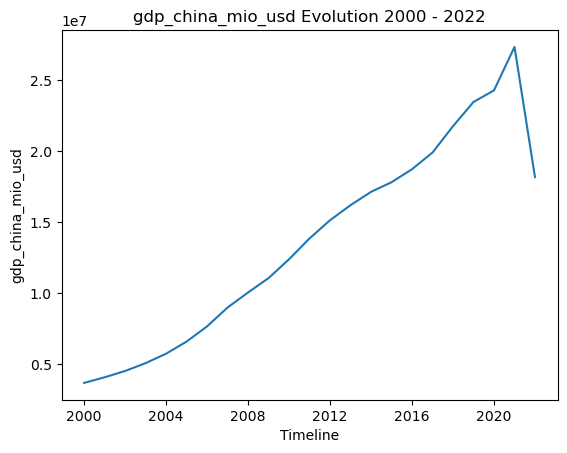

In [181]:
plt.plot(OECD_GDP_China['date'],OECD_GDP_China['gdp_china_mio_usd'],label='gdp_china_mio_usd')
plt.xlabel('Timeline')
plt.ylabel('gdp_china_mio_usd')
plt.title('gdp_china_mio_usd Evolution 2000 - 2022')
#plt.legend()
plt.show()

In [182]:
OECD_GDP_China_daily = upsample(OECD_GDP_China,'2022-01-01','2023-01-01')
OECD_GDP_China_daily.tail()

date gdp_china_mio_usd
8396 2022-12-27        18153105.0
8397 2022-12-28        18153105.0
8398 2022-12-29        18153105.0
8399 2022-12-30        18153105.0
8400 2022-12-31        18153105.0

### Combine data to obtain Dataset

In [183]:
datasets = [data_coffee_price,data_oil_price,weather_data,data_liberal_democracy_top_five_daily,
            prod_top_ten_00_20_harvest, imports_top_countries_00_21_daily, re_exports_top_countries_00_21_daily, OECD_inflation_daily , EA19_unemployment_daily,
            data_currency_USD_EUR, OECD_GDP_China_daily]

#Checking that "date" is in datetime64[ns], since it is going to be the column to be merged.

for dataset in datasets:
    print(dataset.shape)
    print(dataset.dtypes)
    print('----------')


(5763, 3)
date                          datetime64[ns]
volume_coffee_traded                   int64
daily_average_coffee_price           float64
dtype: object
----------
(5615, 2)
date                       datetime64[ns]
daily_average_oil_price           float64
dtype: object
----------
(8398, 25)
date                                  datetime64[ns]
brazil_minas_gerais_PRECTOTCORR              float64
brazil_alta_mogiana_PRECTOTCORR              float64
brazil_rondonia_PRECTOTCORR                  float64
colombia_bella_vista_PRECTOTCORR             float64
colombia_highlands_PRECTOTCORR               float64
ethiopia_kuri_mountain_PRECTOTCORR           float64
ethiopia_shilcho_coop_PRECTOTCORR            float64
vietnam_PRECTOTCORR                          float64
brazil_minas_gerais_latitude                  object
brazil_minas_gerais_longitude                 object
brazil_alta_mogiana_latitude                  object
brazil_alta_mogiana_longitude                 object
brazil_rond

Merge Datasets:

In [184]:
final_dataset = data_coffee_price

for dataset in datasets[1:]:
    final_dataset = final_dataset.merge(dataset,how ='left', on='date')


In [185]:
display(final_dataset.shape)
final_dataset.head()

(5763, 46)

date  volume_coffee_traded  daily_average_coffee_price  \
0 2000-01-04                  5492                  116.375000   
1 2000-01-05                  6165                  116.799999   
2 2000-01-06                  5094                  117.924999   
3 2000-01-07                  6855                  115.950001   
4 2000-01-10                  7499                  121.775002   

   daily_average_oil_price  brazil_minas_gerais_PRECTOTCORR  \
0                      NaN                            34.03   
1                      NaN                             7.35   
2                      NaN                            10.98   
3                      NaN                             1.60   
4                      NaN                             0.05   

   brazil_alta_mogiana_PRECTOTCORR  brazil_rondonia_PRECTOTCORR  \
0                            38.22                        15.80   
1                            10.19                        12.67   
2                             5.65                         2.39   
3                             6.96                         8.44   
4                             1.51                         7.10   

   colombia_bella_vista_PRECTOTCORR  colombia_highlands_PRECTOTCORR  \
0                              7.27                            2.52   
1                             13.92                            0.71   
2                             10.35                            0.74   
3                              7.77                            1.60   
4                              9.26                            0.20   

   ethiopia_kuri_mountain_PRECTOTCORR  ...  indonesia_production  \
0                                0.27  ...                   0.0   
1                                0.17  ...                   0.0   
2                                0.01  ...                   0.0   
3                                0.05  ...                   0.0   
4                                0.24  ...                   0.0   

   ethiopia_production european_union_imports  \
0            25.959575             138.995325   
1            25.959575             138.995325   
2            25.959575             138.995325   
3            25.959575             138.995325   
4            25.959575             138.995325   

  united_states_of_america_imports european_union_reexports  \
0                        66.018998                38.084095   
1                        66.018998                38.084095   
2                        66.018998                38.084095   
3                        66.018998                38.084095   
4                        66.018998                38.084095   

  united_states_of_america_reexports inflation_rate unemployment_rate  \
0                           5.709099        3.95508               9.4   
1                           5.709099        3.95508               9.4   
2                           5.709099        3.95508               9.4   
3                           5.709099        3.95508               9.4   
4                           5.709099        3.95508               9.4   

  daily_exch_usd_eur gdp_china_mio_usd  
0                NaN       3683440.252  
1                NaN       3683440.252  
2                NaN       3683440.252  
3                NaN       3683440.252  
4                NaN       3683440.252  

[5 rows x 46 columns]

#### Save the dataset to csv.file

In [186]:
display(final_dataset.shape)
#save intermediate results:
final_dataset.to_csv('final_dataset.csv', index=False)

(5763, 46)

## Cleaning / Wrangling / EDA

In [187]:
data = pd.read_csv('final_dataset.csv')

In [188]:
display(data.shape)
data.head()

(5763, 46)

date  volume_coffee_traded  daily_average_coffee_price  \
0  2000-01-04                  5492                  116.375000   
1  2000-01-05                  6165                  116.799999   
2  2000-01-06                  5094                  117.924999   
3  2000-01-07                  6855                  115.950001   
4  2000-01-10                  7499                  121.775002   

   daily_average_oil_price  brazil_minas_gerais_PRECTOTCORR  \
0                      NaN                            34.03   
1                      NaN                             7.35   
2                      NaN                            10.98   
3                      NaN                             1.60   
4                      NaN                             0.05   

   brazil_alta_mogiana_PRECTOTCORR  brazil_rondonia_PRECTOTCORR  \
0                            38.22                        15.80   
1                            10.19                        12.67   
2                             5.65                         2.39   
3                             6.96                         8.44   
4                             1.51                         7.10   

   colombia_bella_vista_PRECTOTCORR  colombia_highlands_PRECTOTCORR  \
0                              7.27                            2.52   
1                             13.92                            0.71   
2                             10.35                            0.74   
3                              7.77                            1.60   
4                              9.26                            0.20   

   ethiopia_kuri_mountain_PRECTOTCORR  ...  indonesia_production  \
0                                0.27  ...                   0.0   
1                                0.17  ...                   0.0   
2                                0.01  ...                   0.0   
3                                0.05  ...                   0.0   
4                                0.24  ...                   0.0   

   ethiopia_production  european_union_imports  \
0            25.959575              138.995325   
1            25.959575              138.995325   
2            25.959575              138.995325   
3            25.959575              138.995325   
4            25.959575              138.995325   

   united_states_of_america_imports  european_union_reexports  \
0                         66.018998                 38.084095   
1                         66.018998                 38.084095   
2                         66.018998                 38.084095   
3                         66.018998                 38.084095   
4                         66.018998                 38.084095   

   united_states_of_america_reexports  inflation_rate  unemployment_rate  \
0                            5.709099         3.95508                9.4   
1                            5.709099         3.95508                9.4   
2                            5.709099         3.95508                9.4   
3                            5.709099         3.95508                9.4   
4                            5.709099         3.95508                9.4   

   daily_exch_usd_eur  gdp_china_mio_usd  
0                 NaN        3683440.252  
1                 NaN        3683440.252  
2                 NaN        3683440.252  
3                 NaN        3683440.252  
4                 NaN        3683440.252  

[5 rows x 46 columns]

Function to check the columns and the data types

In [189]:
#check the columns and the data types
def data_colandtype(x):
    data_col = pd.DataFrame(x.iloc[0 , :])
    data_col['type'] = x.dtypes
    data_col = data_col.reset_index()
    data_col.columns = ['header_name', 'row 0', 'type']
    pd.set_option('display.max_rows', None)
    display(data_col)
    return

Function to check the NaN values

In [190]:
#Function to check for NaNs:
def get_percentnan(x):
    data_percentnan = pd.DataFrame(round(x.isna().sum()/len(x),4)*100)
    data_percentnan = data_percentnan.reset_index()
    data_percentnan.columns = ['header_name', 'percent_nan']
    data_percentnan = data_percentnan[(data_percentnan['percent_nan'] > 0)]
    display(data_percentnan)
    return

In [191]:
data_colandtype(data)

header_name        row 0     type
0                                 date   2000-01-04   object
1                 volume_coffee_traded         5492    int64
2           daily_average_coffee_price      116.375  float64
3              daily_average_oil_price          NaN  float64
4      brazil_minas_gerais_PRECTOTCORR        34.03  float64
5      brazil_alta_mogiana_PRECTOTCORR        38.22  float64
6          brazil_rondonia_PRECTOTCORR         15.8  float64
7     colombia_bella_vista_PRECTOTCORR         7.27  float64
8       colombia_highlands_PRECTOTCORR         2.52  float64
9   ethiopia_kuri_mountain_PRECTOTCORR         0.27  float64
10   ethiopia_shilcho_coop_PRECTOTCORR          0.0  float64
11                 vietnam_PRECTOTCORR          0.2  float64
12        brazil_minas_gerais_latitude   -20.993817  float64
13       brazil_minas_gerais_longitude   -45.583318  float64
14        brazil_alta_mogiana_latitude   -20.251462  float64
15       brazil_alta_mogiana_longitude   -47.606327  float64
16            brazil_rondonia_latitude     -9.34034  float64
17           brazil_rondonia_longitude   -63.886297  float64
18       colombia_bella_vista_latitude     4.439678  float64
19      colombia_bella_vista_longitude   -75.815693  float64
20         colombia_highlands_latitude     5.674897  float64
21        colombia_highlands_longitude    -73.47104  float64
22     ethiopia_kuri_mountain_latitude     8.993192  float64
23    ethiopia_kuri_mountain_longitude    34.601556  float64
24      ethiopia_shilcho_coop_latitude     6.489291  float64
25     ethiopia_shilcho_coop_longitude    38.389696  float64
26                    vietnam_latitude    12.766856  float64
27                   vietnam_longitude   108.005089  float64
28                      brazil_lib_dem         0.74  float64
29                    colombia_lib_dem         0.43  float64
30                    ethiopia_lib_dem        0.115  float64
31                   indonesia_lib_dem        0.518  float64
32                     vietnam_lib_dem        0.099  float64
33                   brazil_production          0.0  float64
34                 viet nam_production     98.94206  float64
35                 colombia_production          0.0  float64
36                indonesia_production          0.0  float64
37                 ethiopia_production    25.959575  float64
38              european_union_imports   138.995325  float64
39    united_states_of_america_imports    66.018998  float64
40            european_union_reexports    38.084095  float64
41  united_states_of_america_reexports     5.709099  float64
42                      inflation_rate      3.95508  float64
43                   unemployment_rate          9.4  float64
44                  daily_exch_usd_eur          NaN  float64
45                   gdp_china_mio_usd  3683440.252  float64

In [192]:
data['date'] = pd.to_datetime(data['date'], format='%Y-%m-%d')
data_colandtype(data)

header_name                row 0            type
0                                 date  2000-01-04 00:00:00  datetime64[ns]
1                 volume_coffee_traded                 5492           int64
2           daily_average_coffee_price              116.375         float64
3              daily_average_oil_price                  NaN         float64
4      brazil_minas_gerais_PRECTOTCORR                34.03         float64
5      brazil_alta_mogiana_PRECTOTCORR                38.22         float64
6          brazil_rondonia_PRECTOTCORR                 15.8         float64
7     colombia_bella_vista_PRECTOTCORR                 7.27         float64
8       colombia_highlands_PRECTOTCORR                 2.52         float64
9   ethiopia_kuri_mountain_PRECTOTCORR                 0.27         float64
10   ethiopia_shilcho_coop_PRECTOTCORR                  0.0         float64
11                 vietnam_PRECTOTCORR                  0.2         float64
12        brazil_minas_gerais_latitude           -20.993817         float64
13       brazil_minas_gerais_longitude           -45.583318         float64
14        brazil_alta_mogiana_latitude           -20.251462         float64
15       brazil_alta_mogiana_longitude           -47.606327         float64
16            brazil_rondonia_latitude             -9.34034         float64
17           brazil_rondonia_longitude           -63.886297         float64
18       colombia_bella_vista_latitude             4.439678         float64
19      colombia_bella_vista_longitude           -75.815693         float64
20         colombia_highlands_latitude             5.674897         float64
21        colombia_highlands_longitude            -73.47104         float64
22     ethiopia_kuri_mountain_latitude             8.993192         float64
23    ethiopia_kuri_mountain_longitude            34.601556         float64
24      ethiopia_shilcho_coop_latitude             6.489291         float64
25     ethiopia_shilcho_coop_longitude            38.389696         float64
26                    vietnam_latitude            12.766856         float64
27                   vietnam_longitude           108.005089         float64
28                      brazil_lib_dem                 0.74         float64
29                    colombia_lib_dem                 0.43         float64
30                    ethiopia_lib_dem                0.115         float64
31                   indonesia_lib_dem                0.518         float64
32                     vietnam_lib_dem                0.099         float64
33                   brazil_production                  0.0         float64
34                 viet nam_production             98.94206         float64
35                 colombia_production                  0.0         float64
36                indonesia_production                  0.0         float64
37                 ethiopia_production            25.959575         float64
38              european_union_imports           138.995325         float64
39    united_states_of_america_imports            66.018998         float64
40            european_union_reexports            38.084095         float64
41  united_states_of_america_reexports             5.709099         float64
42                      inflation_rate              3.95508         float64
43                   unemployment_rate                  9.4         float64
44                  daily_exch_usd_eur                  NaN         float64
45                   gdp_china_mio_usd          3683440.252         float64

In [193]:
get_percentnan(data)

header_name  percent_nan
3              daily_average_oil_price         2.79
28                      brazil_lib_dem         4.36
29                    colombia_lib_dem         4.36
30                    ethiopia_lib_dem         4.36
31                   indonesia_lib_dem         4.36
32                     vietnam_lib_dem         4.36
33                   brazil_production         8.75
34                 viet nam_production         8.75
35                 colombia_production         8.75
36                indonesia_production         8.75
37                 ethiopia_production         8.75
38              european_union_imports         4.36
39    united_states_of_america_imports         4.36
40            european_union_reexports         4.36
41  united_states_of_america_reexports         4.36
42                      inflation_rate         0.36
43                   unemployment_rate         0.36
44                  daily_exch_usd_eur        17.32

In [194]:
# We are missing the production values for the years 2021 and 2022.

data = data[(data['date'].dt.year < 2021)]

In [195]:
data.shape

(5259, 46)

In [196]:
get_percentnan(data)

header_name  percent_nan
3   daily_average_oil_price         3.06
44       daily_exch_usd_eur        18.98

In [197]:
# We have only the values for the currency exchange from 2003-12-01 on.
data[data['daily_exch_usd_eur'].isna()== True]

date  volume_coffee_traded  daily_average_coffee_price  \
0    2000-01-04                  5492                  116.375000   
1    2000-01-05                  6165                  116.799999   
2    2000-01-06                  5094                  117.924999   
3    2000-01-07                  6855                  115.950001   
4    2000-01-10                  7499                  121.775002   
5    2000-01-11                  3976                  116.650002   
6    2000-01-12                  5184                  118.474998   
7    2000-01-13                  3717                  119.275002   
8    2000-01-14                 10115                  115.275002   
9    2000-01-18                  7364                  113.875000   
10   2000-01-19                  6626                  116.599998   
11   2000-01-20                  8834                  115.125000   
12   2000-01-21                  5625                  111.599998   
13   2000-01-24                  5821                  111.450001   
14   2000-01-25                  4014                  112.375000   
15   2000-01-26                  5796                  114.075001   
16   2000-01-27                  5477                  114.674999   
17   2000-01-28                  3334                  114.924999   
18   2000-01-31                  6465                  112.549999   
19   2000-02-01                  5964                  111.125000   
20   2000-02-02                  5055                  112.500000   
21   2000-02-03                  4181                  112.474998   
22   2000-02-04                  4107                  112.700001   
23   2000-02-07                  6155                  112.849998   
24   2000-02-08                 11717                  110.400002   
25   2000-02-09                  6700                  108.125000   
26   2000-02-10                  5121                  108.375000   
27   2000-02-11                  6053                  108.775002   
28   2000-02-14                  7749                  106.000000   
29   2000-02-15                  6638                  105.900002   
30   2000-02-16                  8616                  105.224998   
31   2000-02-17                  7419                  105.174999   
32   2000-02-18                  7419                  105.025002   
33   2000-02-22                  1209                  103.099998   
34   2000-02-23                  1237                  103.299999   
35   2000-02-24                   727                  102.825001   
36   2000-02-25                  1908                  100.400002   
37   2000-02-28                   473                   99.950001   
38   2000-02-29                   287                  100.950001   
39   2000-03-01                   166                  101.200001   
40   2000-03-02                   198                  103.799999   
41   2000-03-03                   187                  104.549999   
42   2000-03-06                   106                  104.900002   
43   2000-03-07                   171                  108.200001   
44   2000-03-08                    67                  108.075001   
45   2000-03-09                    93                  107.849998   
46   2000-03-10                   112                  106.049999   
47   2000-03-13                    91                  106.250000   
48   2000-03-14                   198                  104.525002   
49   2000-03-15                   178                  103.000000   
50   2000-03-16                   169                  104.924999   
51   2000-03-17                   138                  105.799999   
52   2000-03-20                   186                  103.924999   
53   2000-03-21                     0                  103.625000   
54   2000-03-22                  3326                  105.150002   
55   2000-03-23                  9191                  103.924999   
56   2000-03-24                  4240                  103.075001   
57   2000

In [198]:
data = data[data['date'].dt.strftime('%Y-%m-%d') > '2003-11-30']

In [199]:
get_percentnan(data)

header_name  percent_nan
3   daily_average_oil_price         0.02
44       daily_exch_usd_eur         0.68

In [200]:
data[data['daily_exch_usd_eur'].isna()== True]

date  volume_coffee_traded  daily_average_coffee_price  \
1196 2004-10-28                 15039                   77.974998   
1420 2005-09-21                     6                   90.349998   
1912 2007-09-10                    25                  117.050003   
1965 2007-11-26                   314                  123.250000   
1981 2007-12-18                  7044                  130.725006   
2050 2008-04-01                 15877                  128.050003   
2072 2008-05-01                   405                  130.949997   
2114 2008-07-01                    62                  151.924995   
2136 2008-08-01                 10356                  139.824997   
2137 2008-08-04                 17075                  138.325005   
2138 2008-08-05                 18712                  138.349998   
2139 2008-08-06                 13345                  139.049995   
2140 2008-08-07                 14575                  139.250000   
2142 2008-08-11                 14993                  135.925003   
2143 2008-08-12                 22949                  136.674995   
2144 2008-08-13                 20193                  136.525002   
2145 2008-08-14                 12193                  135.324997   
2146 2008-08-15                  8303                  133.950005   
2147 2008-08-18                 12441                  133.724998   
2148 2008-08-19                  7795                  135.099998   
2149 2008-08-20                  5671                  136.974998   
2150 2008-08-21                   905                  138.925003   
2151 2008-08-22                   248                  139.800003   
2152 2008-08-25                   415                  139.300003   
3228 2012-12-04                    17                  138.125000   
3440 2013-10-08                  6967                  114.725002   
4382 2017-07-11                     3                  125.649998   
4473 2017-11-16                  9976                  126.625000   
4851 2019-05-22                 26851                   92.375000   

      daily_average_oil_price  brazil_minas_gerais_PRECTOTCORR  \
1196                51.684999                             0.19   
1420                66.510002                             0.01   
1912                76.974998                             0.00   
1965                97.989998                            16.46   
1981                90.730000                             0.97   
2050               101.275002                             0.00   
2072               113.559998                             1.21   
2114               140.574997                             0.00   
2136               124.579998                             0.00   
2137               123.695004                             0.48   
2138               120.084999                             3.75   
2139               118.665001                             0.01   
2140               119.410000                             2.37   
2142               114.824997                             0.01   
2143               113.770000                             0.00   
2144               114.544998                             0.00   
2145               115.700001                             0.00   
2146               114.299999                             0.00   
2147               113.405003                             0.04   
2148               113.820000                             0.00   
2149               115.045002                             0.00   
2150               118.520000                             0.00   
2151               118.070000                             0.00   
2152               114.900002                             0.00   
3228                88.715000                             0.26   
3440               103.325001                             4.01   
4382                44.810001                             0.00   
4473                55.219999                             0.05   
4851                62.029

In [201]:
# Fill NaN-Values with previous value, since there is no pattern to see of the missing values and the mean/median would not fit!
data['daily_exch_usd_eur'] = data['daily_exch_usd_eur'].fillna(method='ffill')

In [202]:
get_percentnan(data)

header_name  percent_nan
3  daily_average_oil_price         0.02

In [203]:
data[data['daily_average_oil_price'].isna()== True]

date  volume_coffee_traded  daily_average_coffee_price  \
1615 2006-07-03                    35                       101.0   

      daily_average_oil_price  brazil_minas_gerais_PRECTOTCORR  \
1615                      NaN                             0.03   

      brazil_alta_mogiana_PRECTOTCORR  brazil_rondonia_PRECTOTCORR  \
1615                             0.01                          0.0   

      colombia_bella_vista_PRECTOTCORR  colombia_highlands_PRECTOTCORR  \
1615                              0.01                            0.01   

      ethiopia_kuri_mountain_PRECTOTCORR  ...  indonesia_production  \
1615                                8.25  ...             62.355614   

      ethiopia_production  european_union_imports  \
1615                  0.0               167.42314   

      united_states_of_america_imports  european_union_reexports  \
1615                         65.857673                 59.780798   

      united_states_of_america_reexports  inflation_rate  unemployment_rate  \
1615                            7.559096         3.16194                8.4   

      daily_exch_usd_eur  gdp_china_mio_usd  
1615            1.279501        7660000.527  

[1 rows x 46 columns]

In [204]:
# Fill NaN-Values with previous value, since there is no pattern to see of the missing values and the mean/median would not fit!
data['daily_average_oil_price'] = data['daily_average_oil_price'].fillna(method='ffill')

In [205]:
get_percentnan(data)

Empty DataFrame
Columns: [header_name, percent_nan]
Index: []

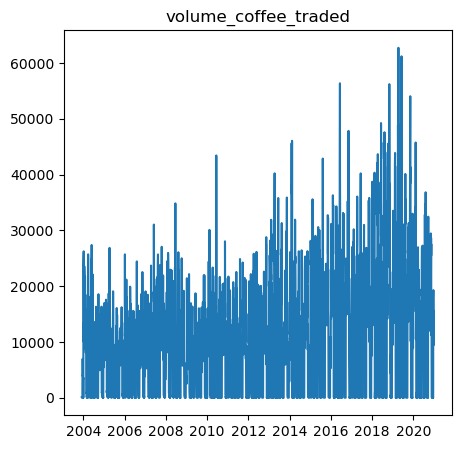

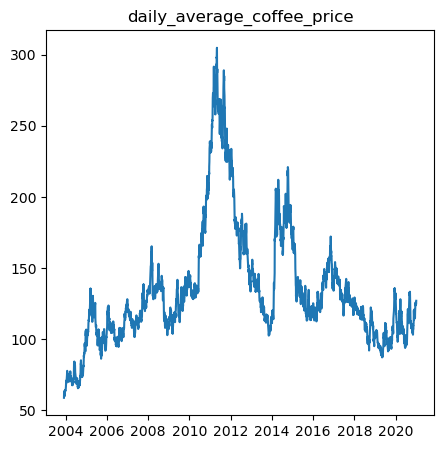

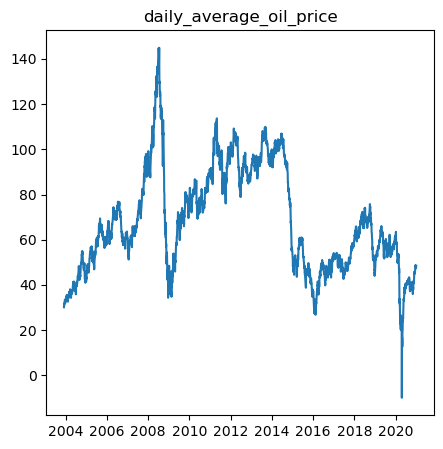

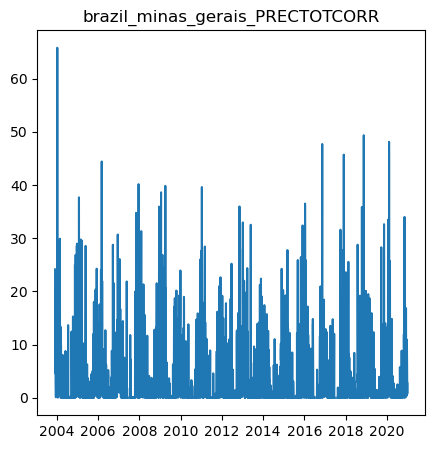

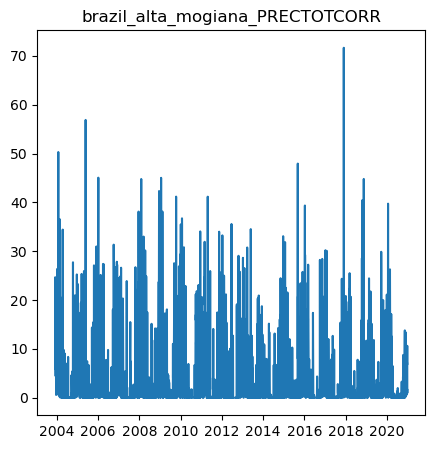

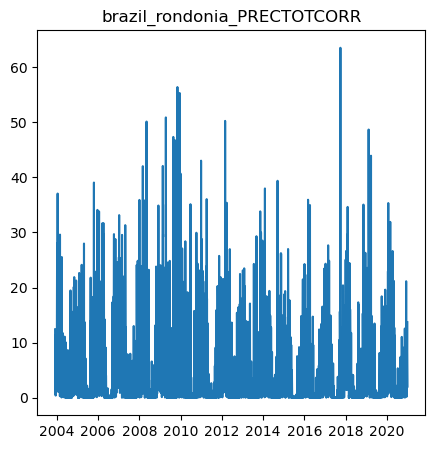

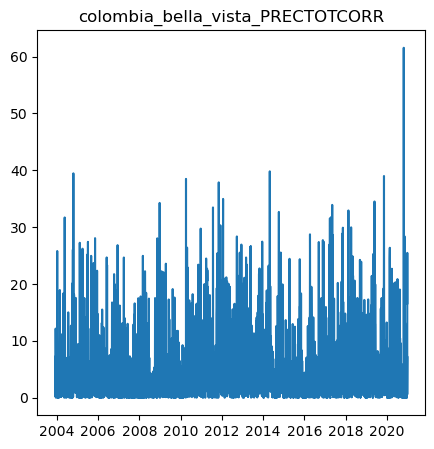

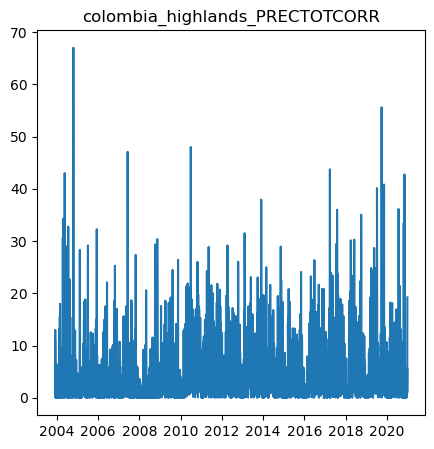

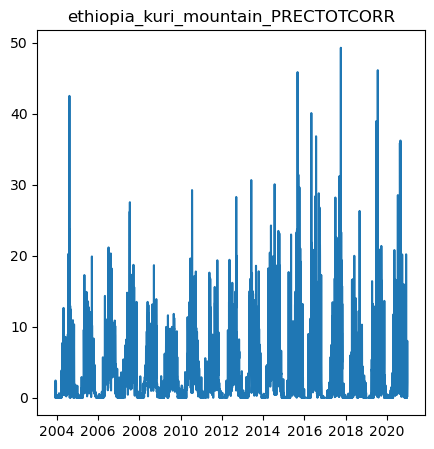

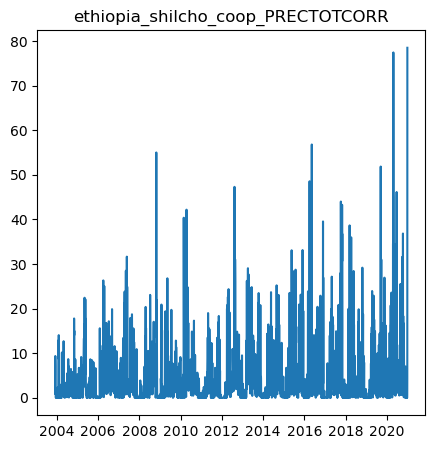

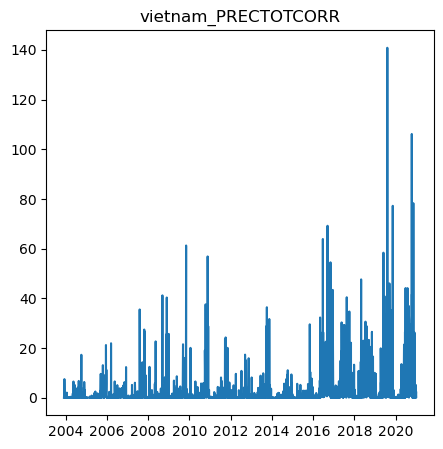

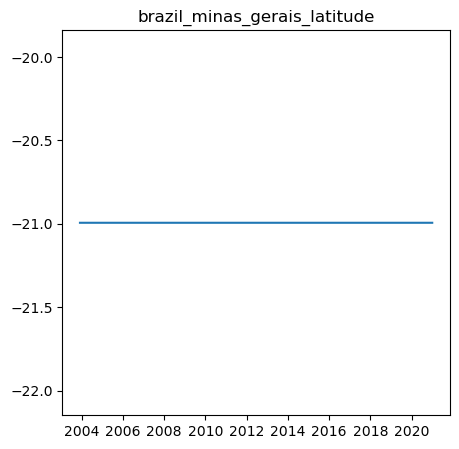

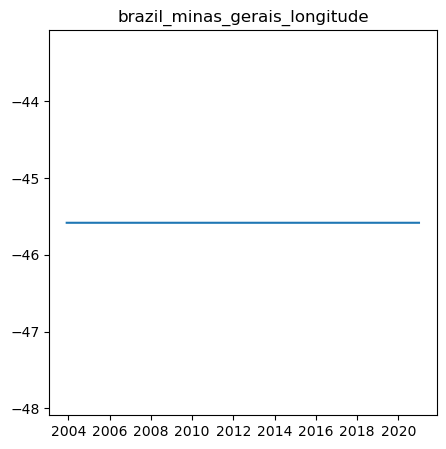

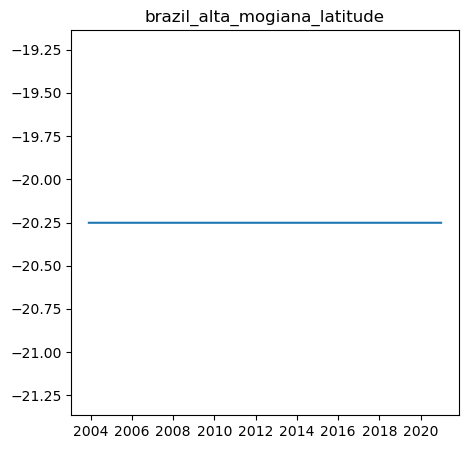

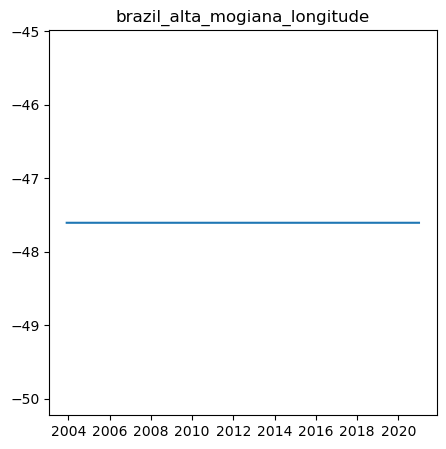

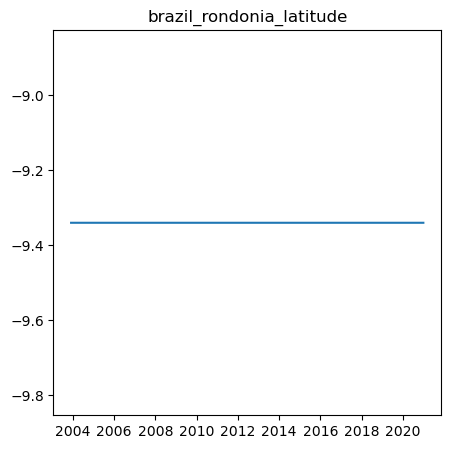

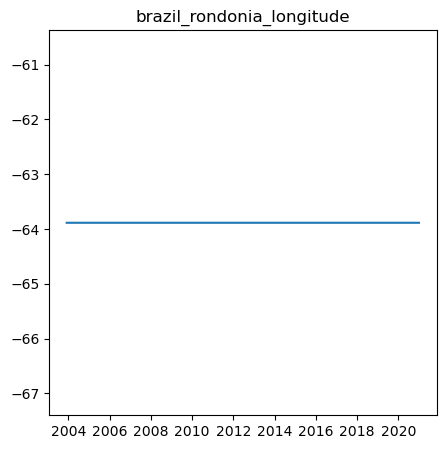

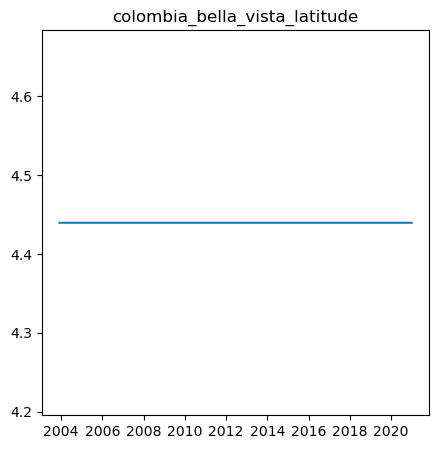

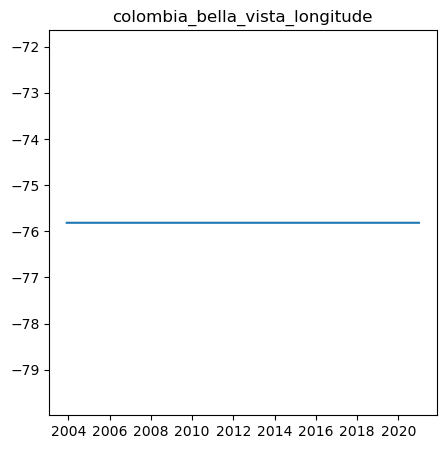

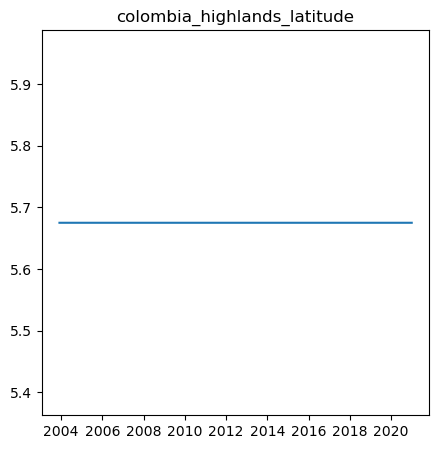

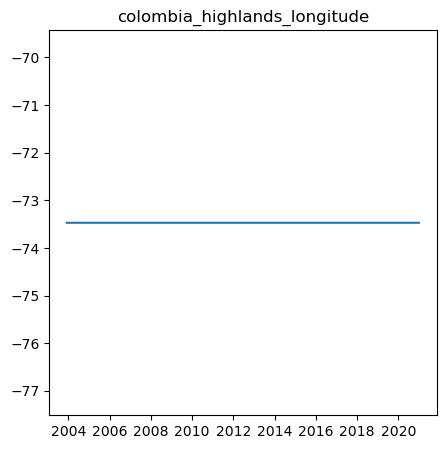

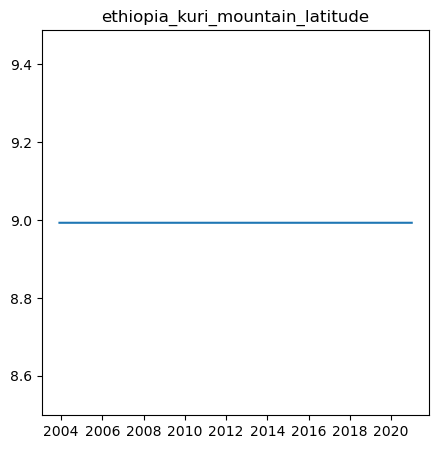

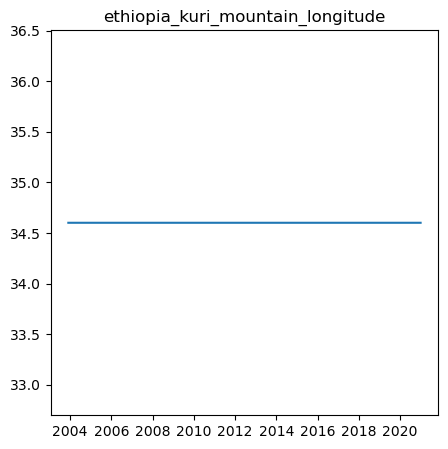

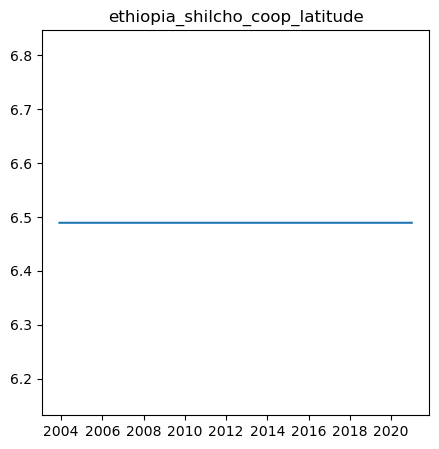

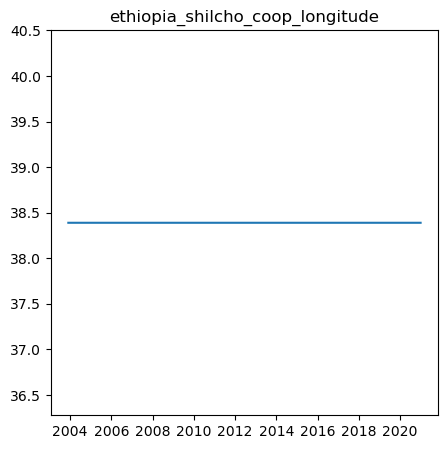

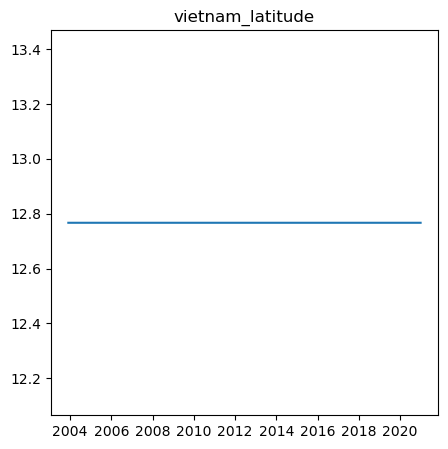

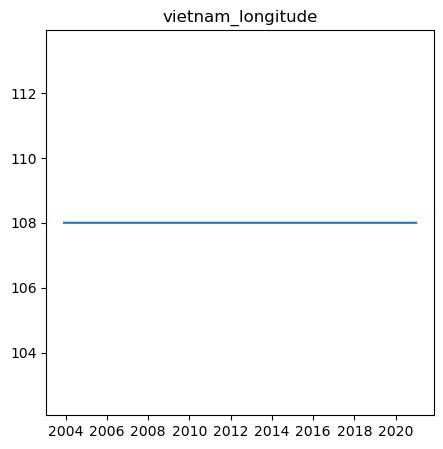

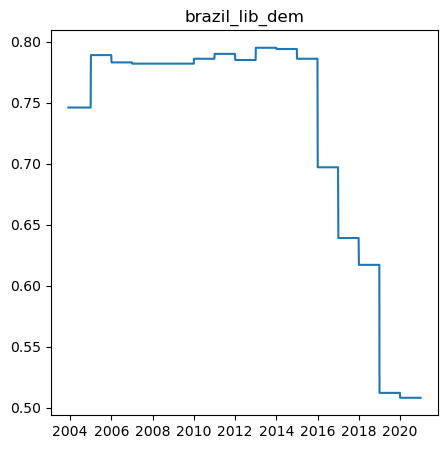

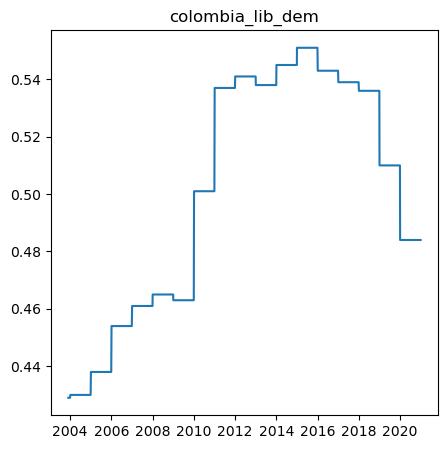

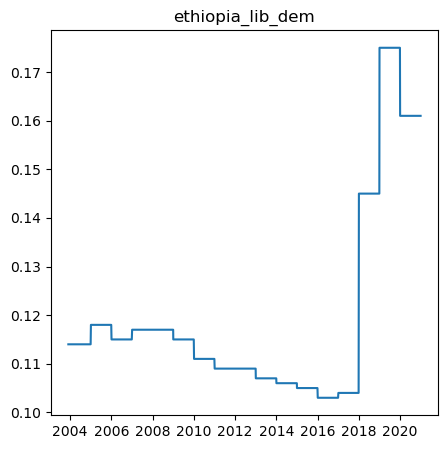

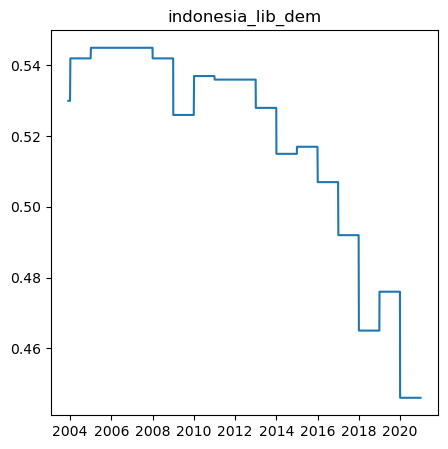

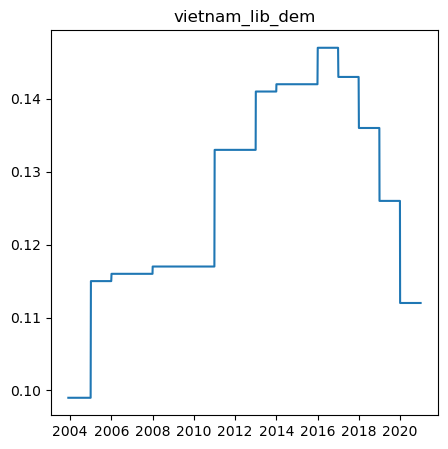

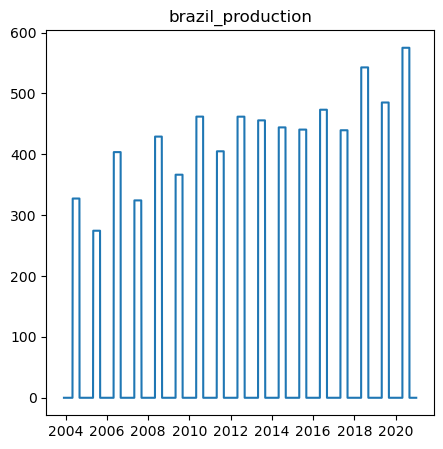

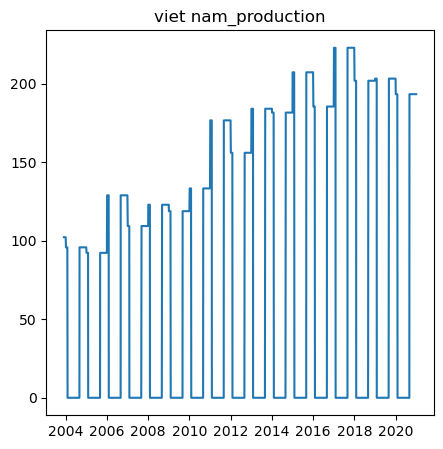

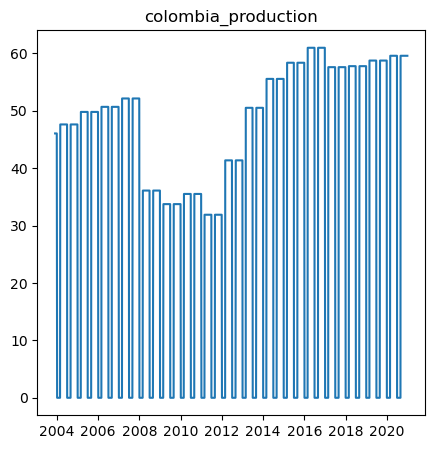

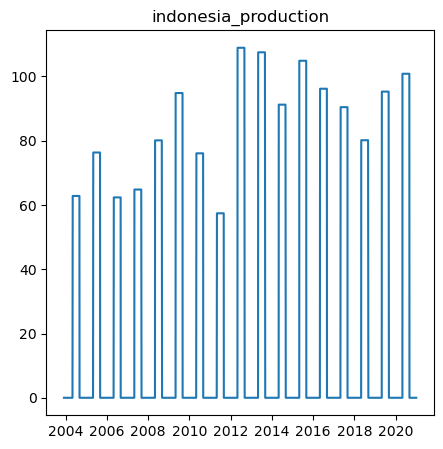

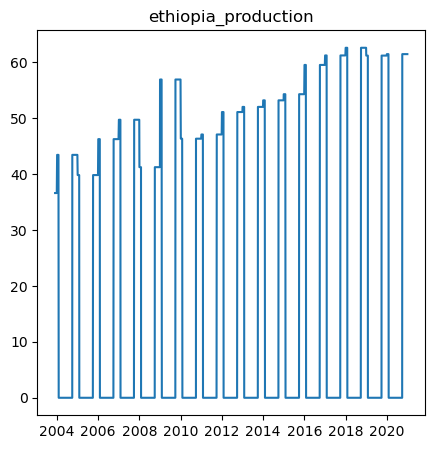

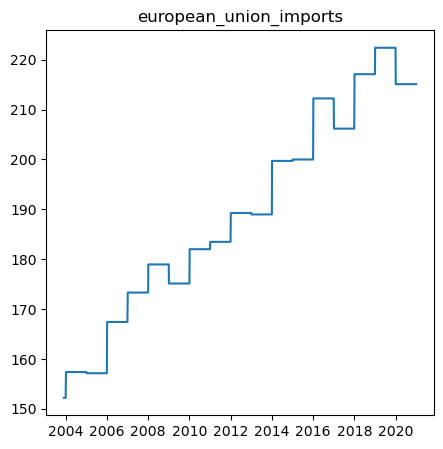

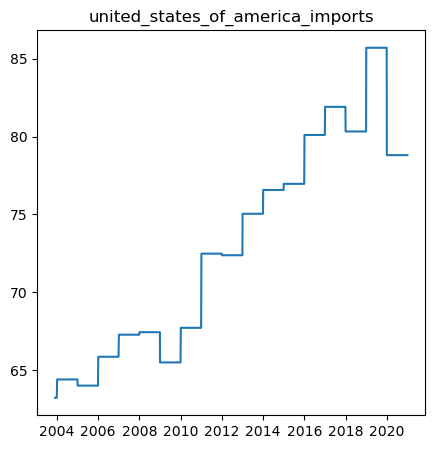

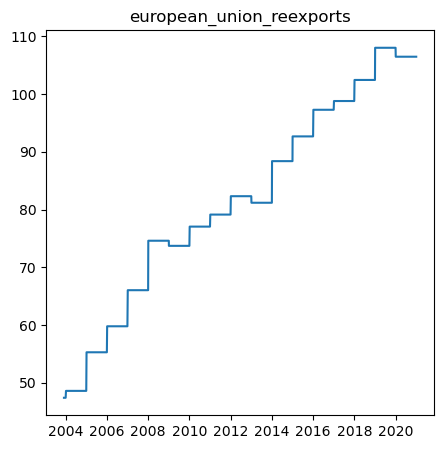

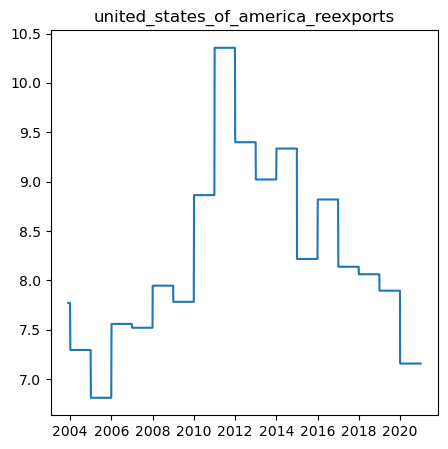

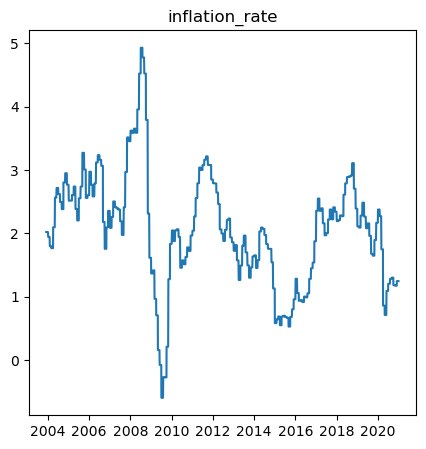

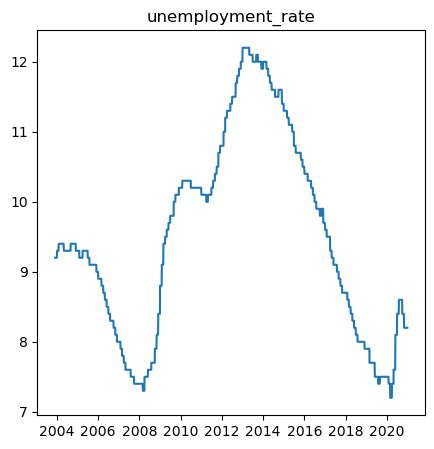

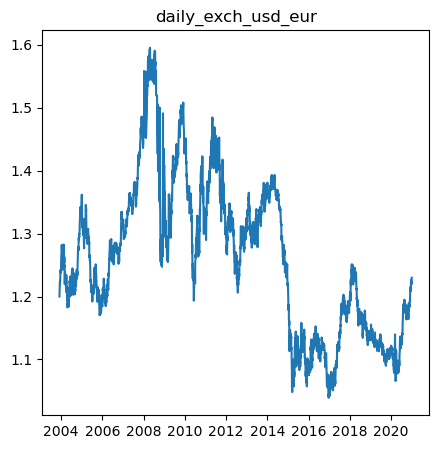

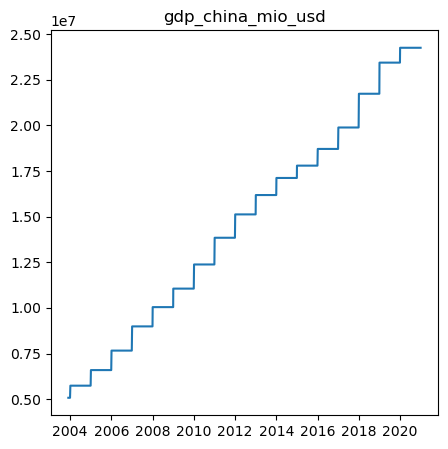

In [206]:
for column in data.columns[1:]:
    plt.figure(figsize=(5, 5))
    plt.plot(data.date,data[column])
    plt.title(column)
    plt.show()

## Modeling

In [207]:
data.columns

Index(['date', 'volume_coffee_traded', 'daily_average_coffee_price',
       'daily_average_oil_price', 'brazil_minas_gerais_PRECTOTCORR',
       'brazil_alta_mogiana_PRECTOTCORR', 'brazil_rondonia_PRECTOTCORR',
       'colombia_bella_vista_PRECTOTCORR', 'colombia_highlands_PRECTOTCORR',
       'ethiopia_kuri_mountain_PRECTOTCORR',
       'ethiopia_shilcho_coop_PRECTOTCORR', 'vietnam_PRECTOTCORR',
       'brazil_minas_gerais_latitude', 'brazil_minas_gerais_longitude',
       'brazil_alta_mogiana_latitude', 'brazil_alta_mogiana_longitude',
       'brazil_rondonia_latitude', 'brazil_rondonia_longitude',
       'colombia_bella_vista_latitude', 'colombia_bella_vista_longitude',
       'colombia_highlands_latitude', 'colombia_highlands_longitude',
       'ethiopia_kuri_mountain_latitude', 'ethiopia_kuri_mountain_longitude',
       'ethiopia_shilcho_coop_latitude', 'ethiopia_shilcho_coop_longitude',
       'vietnam_latitude', 'vietnam_longitude', 'brazil_lib_dem',
       'colombia_lib_dem', '

In [208]:
col_to_drop_lat_long = []
for column in data.columns:
    if ('latitude' in column) | ('longitude' in column):
        col_to_drop_lat_long.append(column)
        
col_to_drop_lat_long

['brazil_minas_gerais_latitude',
 'brazil_minas_gerais_longitude',
 'brazil_alta_mogiana_latitude',
 'brazil_alta_mogiana_longitude',
 'brazil_rondonia_latitude',
 'brazil_rondonia_longitude',
 'colombia_bella_vista_latitude',
 'colombia_bella_vista_longitude',
 'colombia_highlands_latitude',
 'colombia_highlands_longitude',
 'ethiopia_kuri_mountain_latitude',
 'ethiopia_kuri_mountain_longitude',
 'ethiopia_shilcho_coop_latitude',
 'ethiopia_shilcho_coop_longitude',
 'vietnam_latitude',
 'vietnam_longitude']

In [209]:
data.columns

Index(['date', 'volume_coffee_traded', 'daily_average_coffee_price',
       'daily_average_oil_price', 'brazil_minas_gerais_PRECTOTCORR',
       'brazil_alta_mogiana_PRECTOTCORR', 'brazil_rondonia_PRECTOTCORR',
       'colombia_bella_vista_PRECTOTCORR', 'colombia_highlands_PRECTOTCORR',
       'ethiopia_kuri_mountain_PRECTOTCORR',
       'ethiopia_shilcho_coop_PRECTOTCORR', 'vietnam_PRECTOTCORR',
       'brazil_minas_gerais_latitude', 'brazil_minas_gerais_longitude',
       'brazil_alta_mogiana_latitude', 'brazil_alta_mogiana_longitude',
       'brazil_rondonia_latitude', 'brazil_rondonia_longitude',
       'colombia_bella_vista_latitude', 'colombia_bella_vista_longitude',
       'colombia_highlands_latitude', 'colombia_highlands_longitude',
       'ethiopia_kuri_mountain_latitude', 'ethiopia_kuri_mountain_longitude',
       'ethiopia_shilcho_coop_latitude', 'ethiopia_shilcho_coop_longitude',
       'vietnam_latitude', 'vietnam_longitude', 'brazil_lib_dem',
       'colombia_lib_dem', '

In [210]:
data_no_geo = data.drop(col_to_drop_lat_long, axis=1)

### X/y-Split

In [211]:
y = data_no_geo['daily_average_coffee_price']
X = data_no_geo.drop(['daily_average_coffee_price'], axis=1)

### Selecting Best Features with KBest Algorithm

In [212]:
X_num = X.select_dtypes(np.number)
display(X_num.shape)

(4290, 28)

In [213]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
numericals_scaled = MinMaxScaler().fit_transform(X_num)
numericals_scaled = pd.DataFrame(numericals_scaled, columns=X_num.columns)

In [214]:
X_kbest = numericals_scaled
display(X_kbest.shape)

y_kbest = data['daily_average_coffee_price']
display(y_kbest.shape)

(4290, 28)

(4290,)

In [215]:
# # KBest selects the best 10 columns from the f_regression test.

# model based on the 10 best columns
kbest = SelectKBest(score_func=f_regression, k=10).fit(X_kbest, y_kbest) 

#we do not transform, because we are interested in the scores information of the fitting step.
selected = pd.DataFrame(data = kbest.scores_, columns = ['score'])
selected['Column'] = X_kbest.columns
selected
print(selected.sort_values(by = ['score'], ascending = False).head(10))


          score                              Column
23  8476.120609  united_states_of_america_reexports
1   1921.783026             daily_average_oil_price
11  1527.729756                    colombia_lib_dem
25  1059.176666                   unemployment_rate
14   875.958748                     vietnam_lib_dem
26   644.048819                  daily_exch_usd_eur
12   618.532444                    ethiopia_lib_dem
10   518.665271                      brazil_lib_dem
13   152.044841                   indonesia_lib_dem
22    82.034737            european_union_reexports


In [216]:
cols_kbest = selected.sort_values(by = ['score'], ascending = False).head(10)['Column']
list(cols_kbest)

['united_states_of_america_reexports',
 'daily_average_oil_price',
 'colombia_lib_dem',
 'unemployment_rate',
 'vietnam_lib_dem',
 'daily_exch_usd_eur',
 'ethiopia_lib_dem',
 'brazil_lib_dem',
 'indonesia_lib_dem',
 'european_union_reexports']

Choosing Features - KBest

In [217]:
X_selected = X[cols_kbest]
display(X_selected.shape)
X_selected.head()

(4290, 10)

united_states_of_america_reexports  daily_average_oil_price  \
969                            7.770885                30.105000   
970                            7.770885                30.360001   
971                            7.770885                30.950000   
972                            7.770885                31.180000   
973                            7.770885                30.980000   

     colombia_lib_dem  unemployment_rate  vietnam_lib_dem  daily_exch_usd_eur  \
969             0.429                9.2            0.099            1.199950   
970             0.429                9.2            0.099            1.202499   
971             0.429                9.2            0.099            1.210649   
972             0.429                9.2            0.099            1.210049   
973             0.429                9.2            0.099            1.213249   

     ethiopia_lib_dem  brazil_lib_dem  indonesia_lib_dem  \
969             0.114           0.746               0.53   
970             0.114           0.746               0.53   
971             0.114           0.746               0.53   
972             0.114           0.746               0.53   
973             0.114           0.746               0.53   

     european_union_reexports  
969                  47.39468  
970                  47.39468  
971                  47.39468  
972                  47.39468  
973                  47.39468

### Correlation

In [218]:
def getcollinearity(filtered_matrix, column_to_check):
    collinearity = filtered_matrix[(filtered_matrix[column_to_check] >= 0)]
    collinearity = collinearity[column_to_check].sort_values(ascending=False)
    return collinearity

In [219]:
#correlation
Collinearity = pd.concat((y, X_selected), axis=1)
corr_matrix = Collinearity.corr()

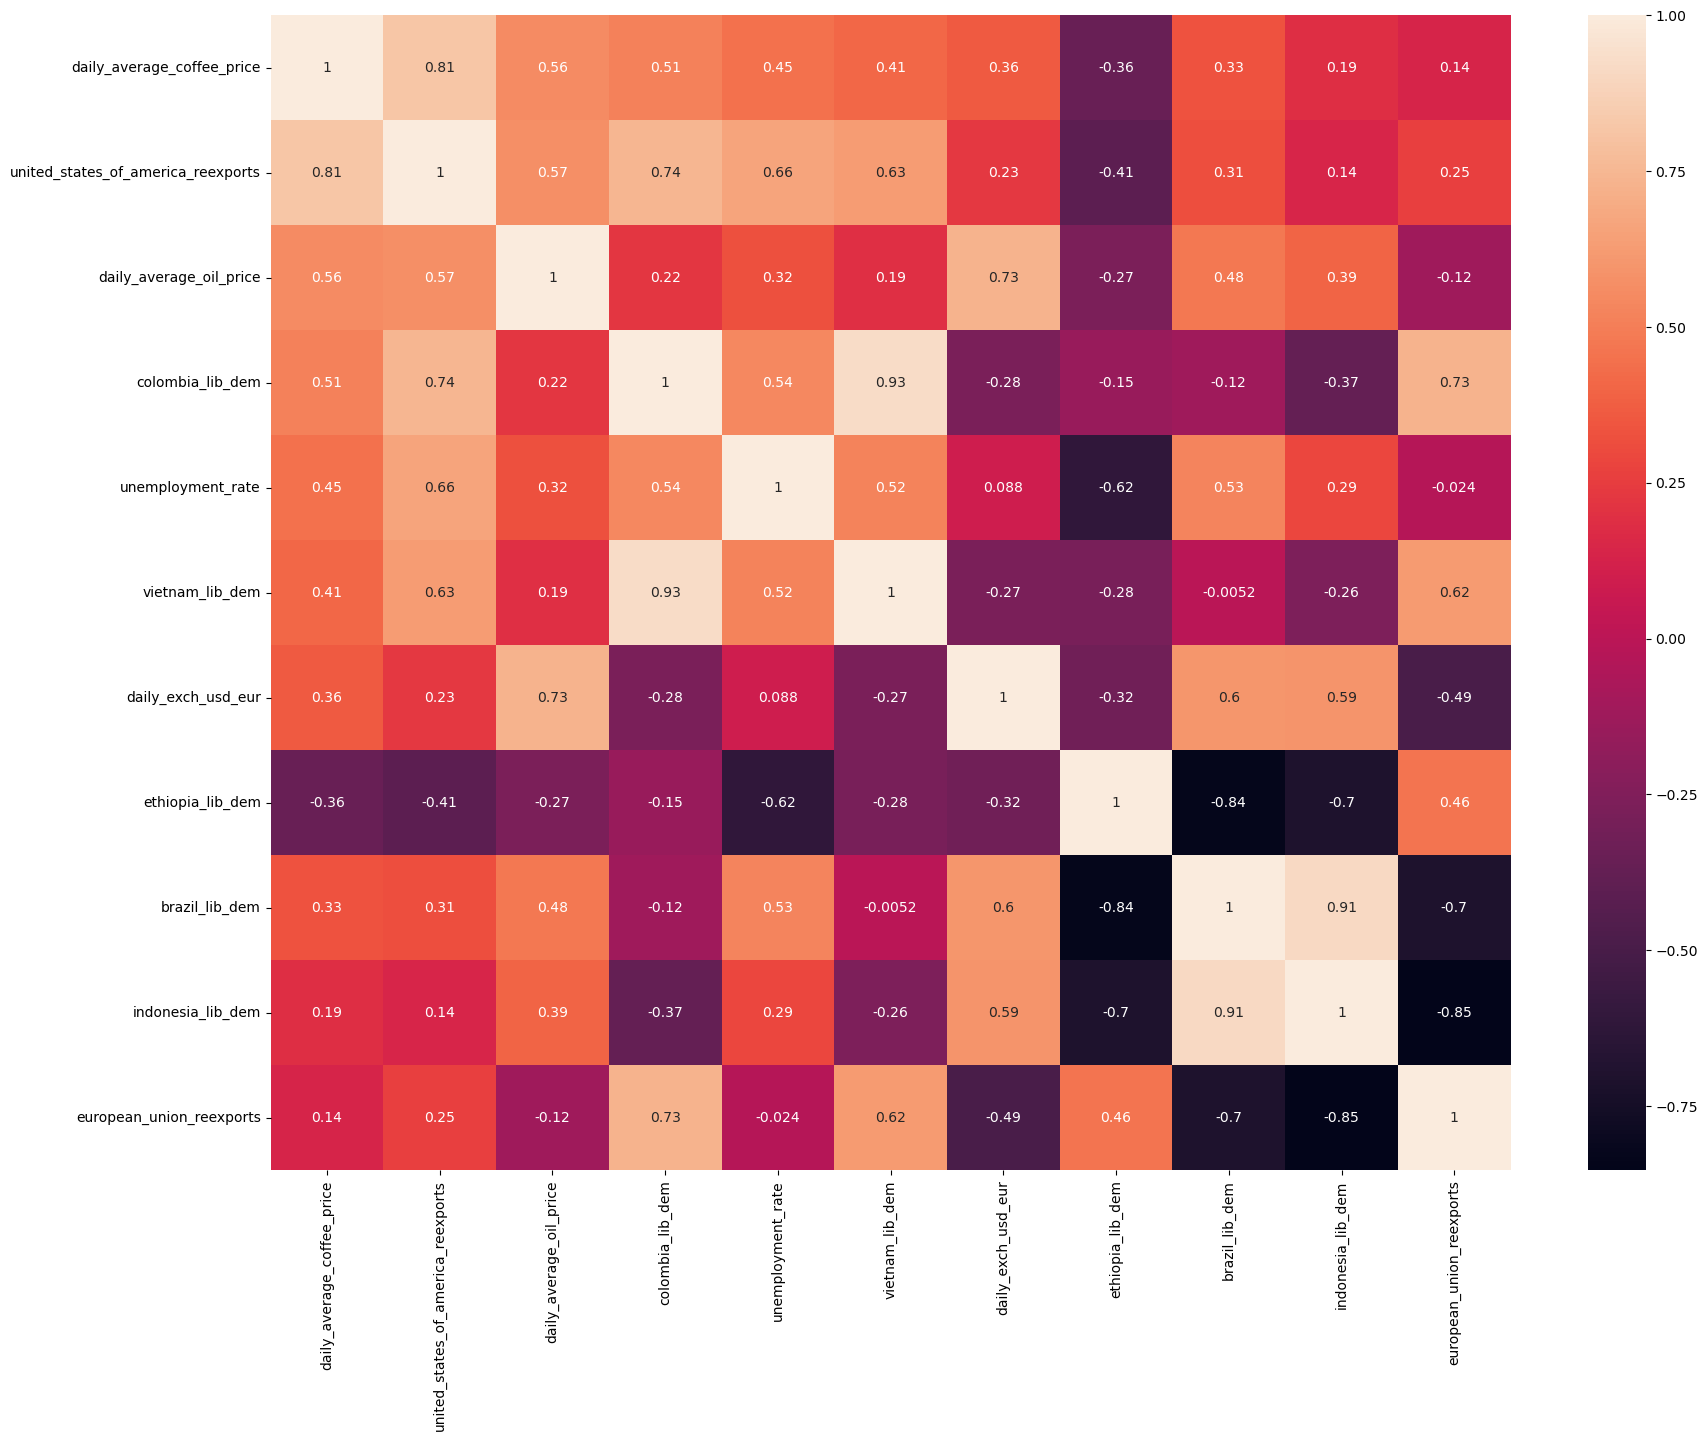

In [220]:
#heatmap
fig, ax = plt.subplots(figsize=(20,15))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

#### Correlations Index:

- 0.9 and 1.0 very highly correlated
- 0.7 and 0.9 highly correlated
- 0.5 and 0.7 moderately correlated
- 0.3 and 0.5 low correlation
- less than 0.3 little if any (linear) correlation. 

In [221]:
correlation_pairs = Collinearity.corr().unstack().abs().sort_values(ascending=False).drop_duplicates()

highly_correlated = correlation_pairs[lambda x : (x > 0.69) & (x != 1)]
highly_correlated

vietnam_lib_dem                     colombia_lib_dem                      0.925691
indonesia_lib_dem                   brazil_lib_dem                        0.908252
                                    european_union_reexports              0.853355
brazil_lib_dem                      ethiopia_lib_dem                      0.837330
united_states_of_america_reexports  daily_average_coffee_price            0.814898
colombia_lib_dem                    united_states_of_america_reexports    0.743522
daily_exch_usd_eur                  daily_average_oil_price               0.730142
colombia_lib_dem                    european_union_reexports              0.728651
brazil_lib_dem                      european_union_reexports              0.703047
ethiopia_lib_dem                    indonesia_lib_dem                     0.702867
dtype: float64

Choosing Features - Correlation

In [222]:
#cols_to_drop_corr = []
cols_to_drop_corr = ['colombia_lib_dem','indonesia_lib_dem','ethiopia_lib_dem']

In [223]:
X_selected = X_selected.drop(columns=cols_to_drop_corr, axis=1)
display(X_selected.shape)
X_selected.head()

(4290, 7)

united_states_of_america_reexports  daily_average_oil_price  \
969                            7.770885                30.105000   
970                            7.770885                30.360001   
971                            7.770885                30.950000   
972                            7.770885                31.180000   
973                            7.770885                30.980000   

     unemployment_rate  vietnam_lib_dem  daily_exch_usd_eur  brazil_lib_dem  \
969                9.2            0.099            1.199950           0.746   
970                9.2            0.099            1.202499           0.746   
971                9.2            0.099            1.210649           0.746   
972                9.2            0.099            1.210049           0.746   
973                9.2            0.099            1.213249           0.746   

     european_union_reexports  
969                  47.39468  
970                  47.39468  
971                  47.39468  
972                  47.39468  
973                  47.39468

### Train/Test-Split

In [224]:
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.20, random_state=42)

In [225]:
X_num_train = X_train.select_dtypes(np.number)
X_num_test = X_test.select_dtypes(np.number)

In [226]:
display(data.shape)
display(X_num_train.shape)
display(X_num_test.shape)

(4290, 46)

(3432, 7)

(858, 7)

### Transformations on numericals: MIN-MAX-Scaling

In [227]:
# Normalizing data: make data range from 0 - 1, instead of from min to max
transformer = MinMaxScaler().fit(X_num_train)
numericals_train_scaled = transformer.transform(X_num_train)
numericals_train_scaled = pd.DataFrame(numericals_train_scaled, columns=X_num_train.columns)

numericals_test_scaled = transformer.transform(X_num_test)
numericals_test_scaled = pd.DataFrame(numericals_test_scaled, columns=X_num_test.columns)

### Combine Train and Test-Data

We only have numerical values, one datetime value and the target values

In [228]:
X_train_processed = numericals_train_scaled
X_test_processed = numericals_test_scaled

### Modelling

#### Choose the best model:

In [229]:
def run_pipeline_regr(X_train_processed, X_test_processed, y_train, y_test):
    linreg = LinearRegression()
    dtreg = DecisionTreeRegressor()
    knreg = KNeighborsRegressor()
    mlp = MLPRegressor(max_iter = 700)
    rfreg = RandomForestRegressor()

    model_pipeline = [linreg, dtreg, knreg, mlp, rfreg]
    model_name = [str(x) for x in model_pipeline]
    
    results = {}

    #--------------
    preds_train = {}
    preds_test = {}
    scores_train = {}
    scores_test = {}
    mses_train = {}
    mses_test = {}
    rmses_train = {}
    rmses_test = {}
    maes_train = {}
    maes_test = {}
    
    for model,name in zip(model_pipeline, model_name):
        #Fitting the model
        model.fit(X_train_processed, y_train)
        #Predicted target trainvalues
        y_pred_train = model.predict(X_train_processed)
        preds_train[name] = y_pred_train
        #Predicted target testvalues
        y_pred_test = model.predict(X_test_processed)
        preds_test[name] = y_pred_test

     
        mean_score_train = np.mean(cross_val_score(model, X_train_processed, y_train, cv = 5))
        scores_train[name] = mean_score_train
        mean_score_test = np.mean(cross_val_score(model, X_test_processed, y_test, cv = 5))
        scores_test[name] = mean_score_test

        mse_train = mean_squared_error(y_pred_train, y_train)
        mse_test = mean_squared_error(y_pred_test, y_test)
        rmse_train = np.sqrt(mse_train)
        rmse_test = np.sqrt(mse_test)
        mae_train = mean_absolute_error(y_pred_train, y_train)
        mae_test = mean_absolute_error(y_pred_test, y_test)

        mses_train[name] = mse_train
        mses_test[name] = mse_test
        rmses_train[name] = rmse_train
        rmses_test[name] = rmse_test
        maes_train[name] = mae_train
        maes_test[name] = mae_test

    return preds_train, scores_train, mses_train, rmses_train, maes_train , preds_test,  scores_test,  mses_test,  rmses_test,  maes_test

In [230]:
preds_train, scores_train, mses_train, rmses_train, maes_train , preds_test,  scores_test,  mses_test,  rmses_test,  maes_test = run_pipeline_regr(X_train_processed, X_test_processed, y_train, y_test)

In [231]:
scores_train

{'LinearRegression()': 0.7164831404517376,
 'DecisionTreeRegressor()': 0.9723434609257151,
 'KNeighborsRegressor()': 0.9789625199628029,
 'MLPRegressor(max_iter=700)': 0.8283020933166825,
 'RandomForestRegressor()': 0.9830521950474855}

In [232]:
scores_test

{'LinearRegression()': 0.6978312837557412,
 'DecisionTreeRegressor()': 0.9463961594858084,
 'KNeighborsRegressor()': 0.948255858531792,
 'MLPRegressor(max_iter=700)': 0.6018666695395116,
 'RandomForestRegressor()': 0.9652872389804357}

In [233]:
rmses_test

{'LinearRegression()': 22.57560563977217,
 'DecisionTreeRegressor()': 5.851101399529018,
 'KNeighborsRegressor()': 6.563525837174592,
 'MLPRegressor(max_iter=700)': 16.425720653994997,
 'RandomForestRegressor()': 4.761381109468547}

Interpreting the results, thee RandomForestRegressor is the best model to use for the coffee price predictions.

### Hyperparameter search: Grid Search

In [234]:
max_depth_choices= [3,10,None]
criterion_choices = ['squared_error','absolute_error']
min_samples_split_choices = [2,10]
min_samples_leaf_choices = [2,10]

In [235]:
# Create the  grid 
# this is a dictionary from hyperparameters to potential values
# the keys in this dictionary have to match the names of the hyperparameters in the documentation of the model
grid = {'max_depth': max_depth_choices,
        'criterion': criterion_choices,
        'min_samples_split': min_samples_split_choices,
        'min_samples_leaf': min_samples_leaf_choices}

In [236]:
# Instantiate the grid search model object

# estimator -> model to optimize 
model = RandomForestRegressor()
# param_grid -> state the dictionary of parameters to optimize
# cv = 5 -> number of cross validation folds <------ CV is REALLY important in grid search. Why?
grid_search = GridSearchCV(estimator = model, param_grid = grid, cv = 5)#, n_jobs = -1)
#we are going to build 24 model * 5 cross validation folds = 120 models

In [237]:
# Fit the grid search to the data
grid_search.fit(X_train_processed, y_train)

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'criterion': ['squared_error', 'absolute_error'],
                         'max_depth': [3, 10, None],
                         'min_samples_leaf': [2, 10],
                         'min_samples_split': [2, 10]})

In [238]:
# and the winner is...
grid_search.best_params_

{'criterion': 'absolute_error',
 'max_depth': None,
 'min_samples_leaf': 2,
 'min_samples_split': 2}

In [239]:
# in grid search you are more likely to get really good results in your training set, even with CV
grid_search.best_score_

0.9827012446105936

## Apply Model on the whole dataset:

In [240]:
X_full_processed = numericals_scaled[cols_kbest]
X_full_processed = X_full_processed.drop(columns=cols_to_drop_corr, axis=1)
X_full_processed.shape

(4290, 7)

In [241]:
model = RandomForestRegressor(criterion= 'squared_error', min_samples_leaf= 2) 
# 'max_depth': None, 'min_samples_split': 2 --> are default parameters 

#Fitting the model
model.fit(X_train_processed, y_train)

#Predicted target trainvalues
y_pred_train = model.predict(X_train_processed)
#Predicted target testvalues
y_pred_test = model.predict(X_test_processed)

r2_test = r2_score(y_test, y_pred_test)
mse_test = mean_squared_error(y_pred_test, y_test)
mae_test = mean_absolute_error(y_pred_test, y_test)

In [242]:
display(r2_test)
display(np.sqrt(mse_test))
display(mae_test)

0.9865281407600996

4.885078534686561

3.279194215692166

In [243]:
y_pred_full = model.predict(X_full_processed)

In [244]:
data['coffee_prices_pred'] = y_pred_full

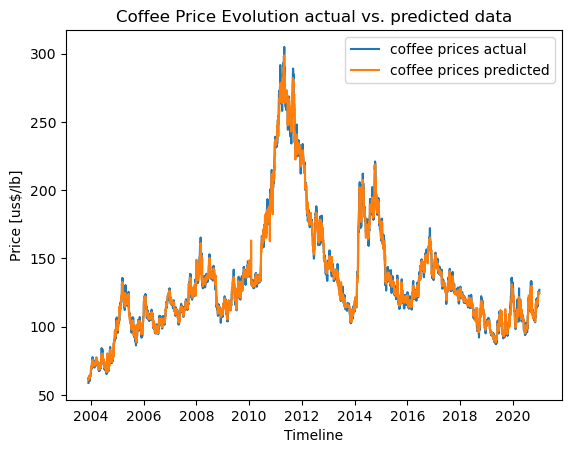

In [245]:
plt.plot(data.date,data['daily_average_coffee_price'],label = 'coffee prices actual')
plt.plot(data.date,data['coffee_prices_pred'],label='coffee prices predicted')
plt.legend()
plt.xlabel('Timeline')
plt.ylabel('Price [us$/lb]')
plt.title('Coffee Price Evolution actual vs. predicted data')
plt.show()

#### Save the dataset to csv.file

In [246]:
display(data.shape)
#save intermediate results:
data.to_csv('data_predicted.csv', index=False)

(4290, 47)